# 20250402 - parse result of COMSOL parametric sweep
* Specifically emerging from simulation of photobleached species in a circular region in contact with bath from which recovery emerges.
* The COMSOL model file is `/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/2025_3D_nosurfbinding.mph`.


In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
import matplotlib.colors as mcolors
import matplotlib.cm as cm
sns.set_style('ticks')

import numpy as np
import scipy
import glob

In [2]:
fname='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250402_sweepKbleach_.csv'
chimney = pd.read_csv(fname)
chimney=chimney[['kbleach (1/s)', 'Time (s)', 'U (mol/m^3)']]
chimney

kbleach (1/s)  Time (s)   U (mol/m^3)
0            0.0001       0.0  3.000000e-03
1            0.0001      50.0  2.990400e-03
2            0.0001     100.0  2.984500e-03
3            0.0001     150.0  2.979800e-03
4            0.0001     200.0  2.976600e-03
...             ...       ...           ...
2608       100.0000    9800.0  9.800900e-08
2609       100.0000    9850.0  9.790900e-08
2610       100.0000    9900.0  9.781000e-08
2611       100.0000    9950.0  9.771200e-08
2612       100.0000   10000.0  9.761500e-08

[2613 rows x 3 columns]

In [3]:
chimney.head()

kbleach (1/s)  Time (s)  U (mol/m^3)
0         0.0001       0.0     0.003000
1         0.0001      50.0     0.002990
2         0.0001     100.0     0.002985
3         0.0001     150.0     0.002980
4         0.0001     200.0     0.002977

In [4]:
kbleachList=chimney['kbleach (1/s)'].unique()

In [5]:
len(kbleachList)

13

In [7]:
sns.color_palette('mako', as_cmap=True)(0.5)

(0.20692679, 0.48201774, 0.63812656, 1.0)

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

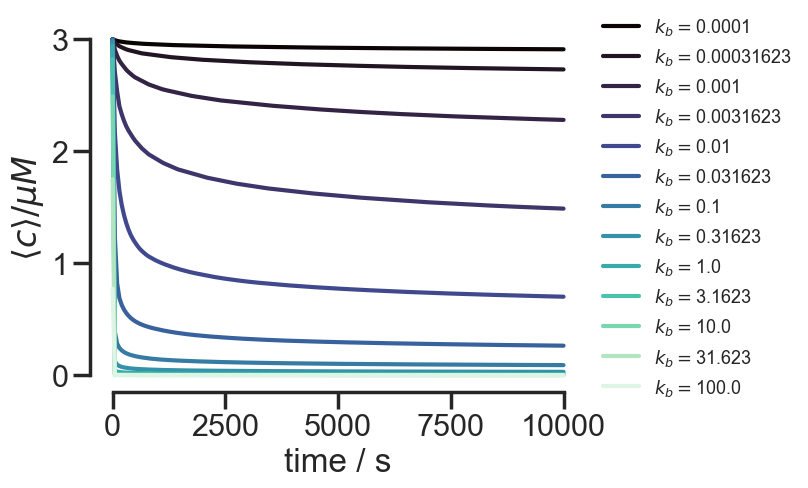

In [10]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.plot(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii],
            label=r'$k_b=$'+str(kbleach))

sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

In [11]:
chimney_subset['Time (s)'].values[-1]

10000.0

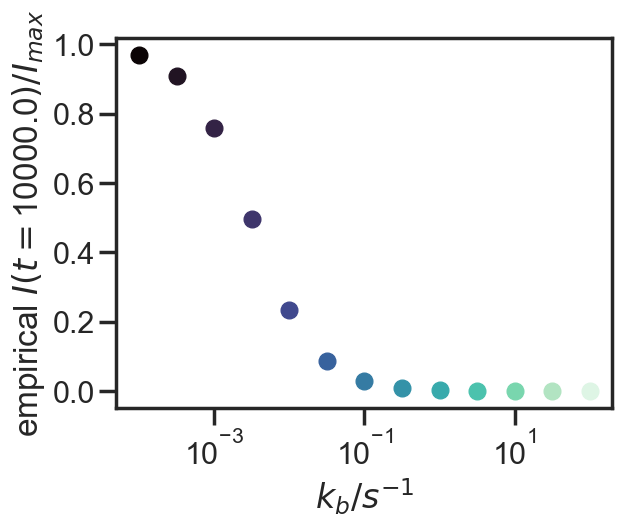

In [12]:
for ii in range(len(kbleachList)):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleachList[ii]]
    plt.plot(kbleachList[ii], chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].values.max(), 'o', color=colorList[ii])
plt.ylabel("empirical $I(t=$"+str(chimney_subset['Time (s)'].values[-1])+'$)/I_{max}$')
plt.xlabel('$k_b / s^{-1}$')
plt.xscale('log')

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

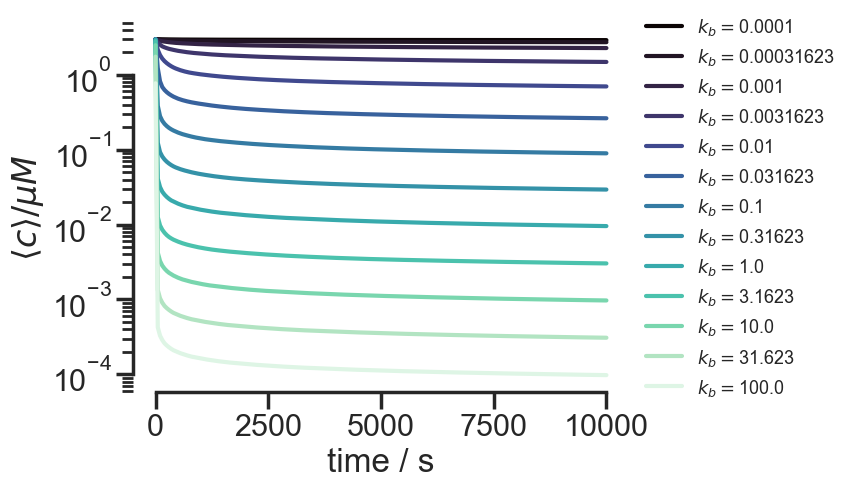

In [13]:

colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.plot(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii],
            label=r'$k_b=$'+str(kbleach))

    
plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

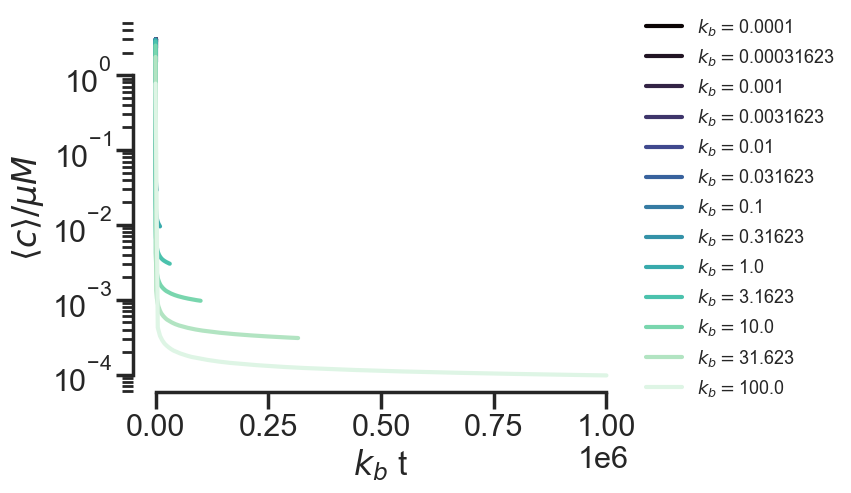

In [14]:
### Try simplest data collapse,
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.plot(chimney_subset['Time (s)']*kbleach, 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii],
            label=r'$k_b=$'+str(kbleach))

    
plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('$k_b$ t')
plt.ylabel(r'$\langle c \rangle / \mu M$')

# we be plottin

In [20]:
tol=1e-8
#--------------------------------------------------------------------#
def singExpConst_max1(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [ tau1, Iinf], where tau1 is the decay constant of the exponential and Iinf is the limit of the intensity as you go to infinity
    """
    tau1 = p0[0]
    Iinf = p0[1]

    return (1-Iinf)*np.exp(-times/tau1)+Iinf
    
def singExpConstFit_max1(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExpConst_max1(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def doubExp_max1(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [tau1, w2, tau2], where tau1(2) is the decay constant of the first(second) exponential and Iinf is the limit of the intensity as you go to infinity
    """
    tau1 = p0[0]
    Iinf = p0[1]
    tau2 = p0[2]

    return (1-Iinf)*np.exp(-times/tau1)+Iinf*np.exp(-times/tau2)
    
def doubExpFit_max1(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExp_max1(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

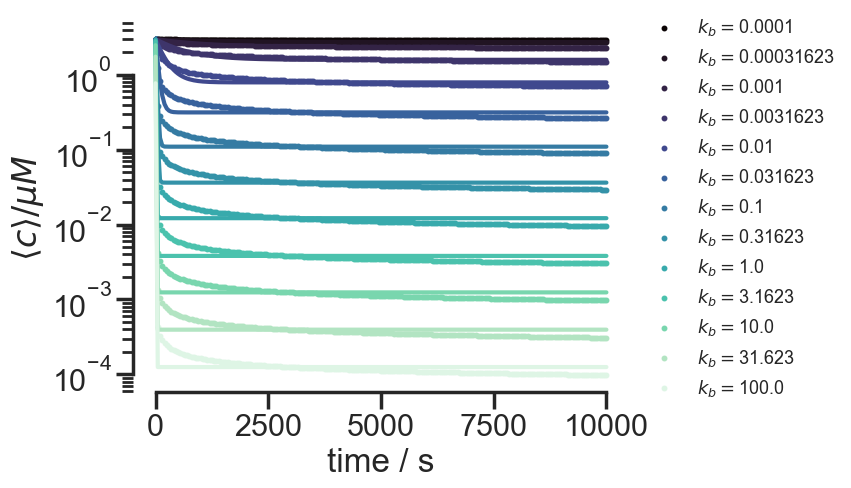

In [16]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = singExpConstFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max()))
    
    plt.plot(chimney_subset['Time (s)'], 
             singExpConst_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

In [17]:
chimney_subset['Time (s)'].head(81)

2412       0.0
2413      50.0
2414     100.0
2415     150.0
2416     200.0
         ...  
2488    3800.0
2489    3850.0
2490    3900.0
2491    3950.0
2492    4000.0
Name: Time (s), Length: 81, dtype: float64

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

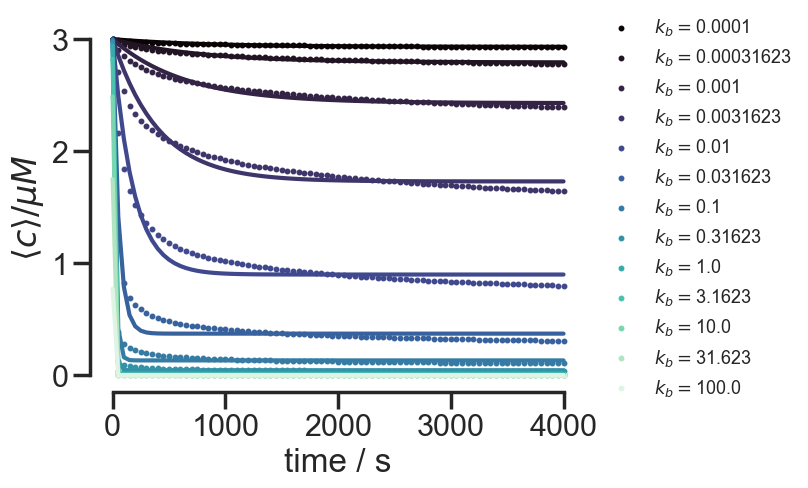

In [18]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'][:81], 
             10**3*chimney_subset['U (mol/m^3)'][:81], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = singExpConstFit_max1(chimney_subset['Time (s)'][:81], 
                                    chimney_subset['U (mol/m^3)'][:81]/chimney_subset['U (mol/m^3)'][:81].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'][:81].values[-1]/chimney_subset['U (mol/m^3)'][:81].max()))
    
    plt.plot(chimney_subset['Time (s)'][:81], 
             singExpConst_max1(chimney_subset['Time (s)'][:81],temp_fit.x)*chimney_subset['U (mol/m^3)'][:81].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

      fun: 0.0005630534676843565
 hess_inv: array([[ 5.96456362e+08, -1.60717609e+03],
       [-1.60717609e+03,  7.60819923e-03]])
      jac: array([ 3.78349796e-10, -9.04172339e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 330
      nit: 39
     njev: 106
   status: 2
  success: False
        x: array([1.52027328e+03, 9.71825524e-01])
      fun: 0.005112452440529113
 hess_inv: array([[ 1.98195692e+02, -1.89972886e-03],
       [-1.89972886e-03,  2.73518606e-03]])
      jac: array([-5.82076609e-11,  5.76494494e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 257
      nit: 22
     njev: 82
   status: 2
  success: False
        x: array([1.41563426e+03, 9.16146221e-01])
      fun: 0.03873255696044571
 hess_inv: array([[1.25305694e+02, 3.47938167e-02],
       [3.47938167e-02, 2.99639402e-03]])
      jac: array([4.65661287e-10, 2.38604844e-06])
  message: 'Desired error not necessarily achieved due to 

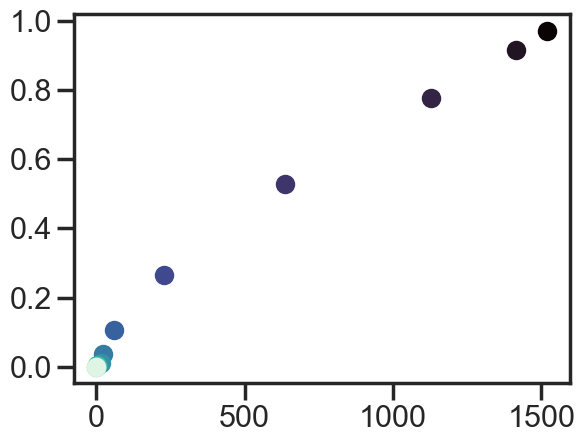

In [19]:
for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    temp_fit = singExpConstFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, 0.75))
    print(temp_fit)
    plt.scatter(temp_fit.x[0], temp_fit.x[1], color = colorList[ii])

      fun: 0.012783718884894992
 hess_inv: array([[4.10081932e+10, 1.53833534e+07, 7.31881289e+09],
       [1.53833534e+07, 5.83865109e+03, 2.74549736e+06],
       [7.31881289e+09, 2.74549736e+06, 1.30620293e+09]])
      jac: array([ 2.18860805e-08, -3.26900044e-05, -1.01281330e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 648
      nit: 82
     njev: 159
   status: 2
  success: False
        x: array([1.05928275e+05, 5.95992283e+00, 1.17120504e+05])
      fun: 0.0008229596765481613
 hess_inv: array([[4.61950221e+03, 1.72321467e-01, 8.39299514e+03],
       [1.72321467e-01, 1.97653999e-03, 3.11679330e-01],
       [8.39299514e+03, 3.11679330e-01, 1.52626452e+04]])
      jac: array([1.45519152e-10, 2.57228385e-06, 2.40106601e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 843
      nit: 78
     njev: 206
   status: 2
  success: False
        x: array([6.13663932e+02, 9.40863205e-01, 2.73125094e+05])


Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

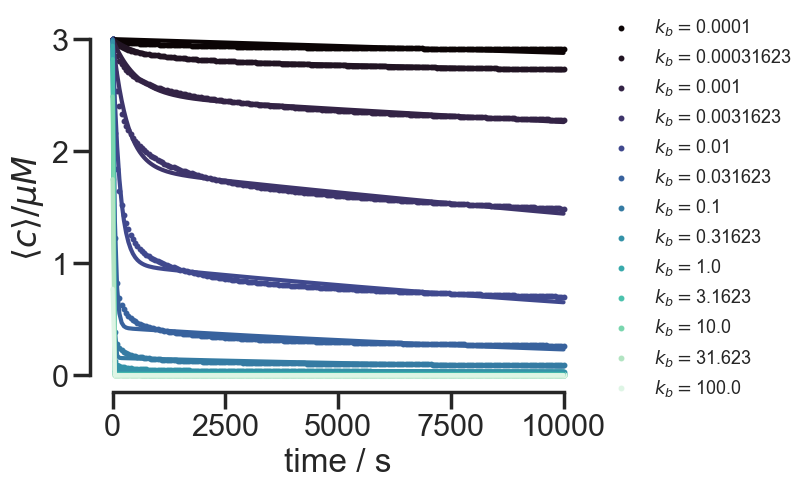

In [20]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    print(temp_fit)
    
    plt.plot(chimney_subset['Time (s)'], 
             doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')



      fun: 0.012783718884894992
 hess_inv: array([[4.10081932e+10, 1.53833534e+07, 7.31881289e+09],
       [1.53833534e+07, 5.83865109e+03, 2.74549736e+06],
       [7.31881289e+09, 2.74549736e+06, 1.30620293e+09]])
      jac: array([ 2.18860805e-08, -3.26900044e-05, -1.01281330e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 648
      nit: 82
     njev: 159
   status: 2
  success: False
        x: array([1.05928275e+05, 5.95992283e+00, 1.17120504e+05])
      fun: 0.0008229596765481613
 hess_inv: array([[4.61950221e+03, 1.72321467e-01, 8.39299514e+03],
       [1.72321467e-01, 1.97653999e-03, 3.11679330e-01],
       [8.39299514e+03, 3.11679330e-01, 1.52626452e+04]])
      jac: array([1.45519152e-10, 2.57228385e-06, 2.40106601e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 843
      nit: 78
     njev: 206
   status: 2
  success: False
        x: array([6.13663932e+02, 9.40863205e-01, 2.73125094e+05])


Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

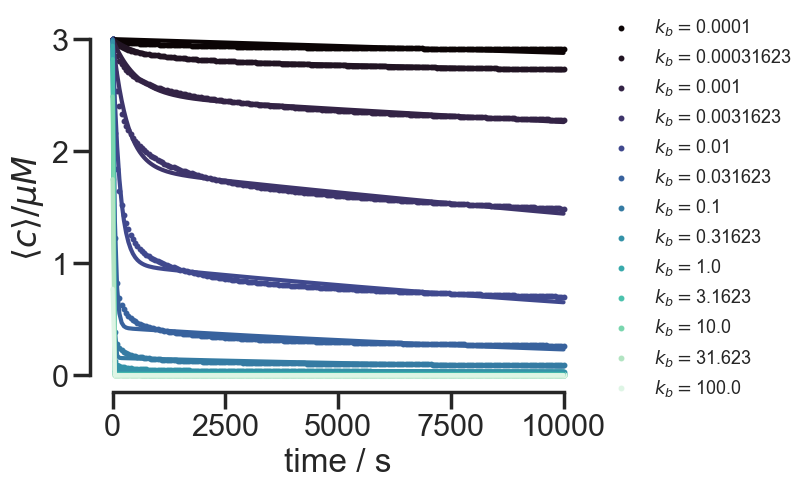

In [26]:
#### start here

colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    print(temp_fit)
    
    plt.plot(chimney_subset['Time (s)'], 
             doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')



      fun: 0.012783718884894992
 hess_inv: array([[4.10081932e+10, 1.53833534e+07, 7.31881289e+09],
       [1.53833534e+07, 5.83865109e+03, 2.74549736e+06],
       [7.31881289e+09, 2.74549736e+06, 1.30620293e+09]])
      jac: array([ 2.18860805e-08, -3.26900044e-05, -1.01281330e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 648
      nit: 82
     njev: 159
   status: 2
  success: False
        x: array([1.05928275e+05, 5.95992283e+00, 1.17120504e+05])
      fun: 0.0008229596765481613
 hess_inv: array([[4.61950221e+03, 1.72321467e-01, 8.39299514e+03],
       [1.72321467e-01, 1.97653999e-03, 3.11679330e-01],
       [8.39299514e+03, 3.11679330e-01, 1.52626452e+04]])
      jac: array([1.45519152e-10, 2.57228385e-06, 2.40106601e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 843
      nit: 78
     njev: 206
   status: 2
  success: False
        x: array([6.13663932e+02, 9.40863205e-01, 2.73125094e+05])


No handles with labels found to put in legend.


      fun: 0.02552355133072811
 hess_inv: array([[ 3.51599121e+00,  1.30021572e-03, -2.28390625e+02],
       [ 1.30021572e-03,  8.87566128e-03, -1.32625642e+03],
       [-2.28390625e+02, -1.32625642e+03,  4.74379327e+08]])
      jac: array([6.98491931e-10, 6.56815246e-07, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 552
      nit: 61
     njev: 135
   status: 2
  success: False
        x: array([5.01410045e+01, 1.41925271e-01, 1.62024249e+04])
      fun: 0.0053381336763369935
 hess_inv: array([[ 7.15339743e+03,  1.02659331e+00, -3.80418569e+06],
       [ 1.02659331e+00,  2.77161960e-03,  2.95846451e+02],
       [-3.80418569e+06,  2.95846451e+02,  4.54762378e+09]])
      jac: array([ 1.33877620e-09, -4.29828651e-06,  1.16415322e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 508
      nit: 63
     njev: 124
   status: 2
  success: False
        x: array([2.07093621e+01, 5.15132241e-02, 

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

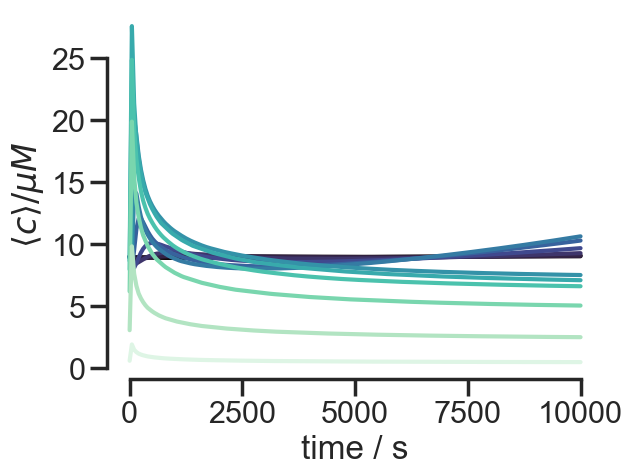

In [27]:
####### plot multiplicative residual

#### start here

colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    print(temp_fit)
    
    plt.plot(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)']/doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')



(-100.0, 2500.0)

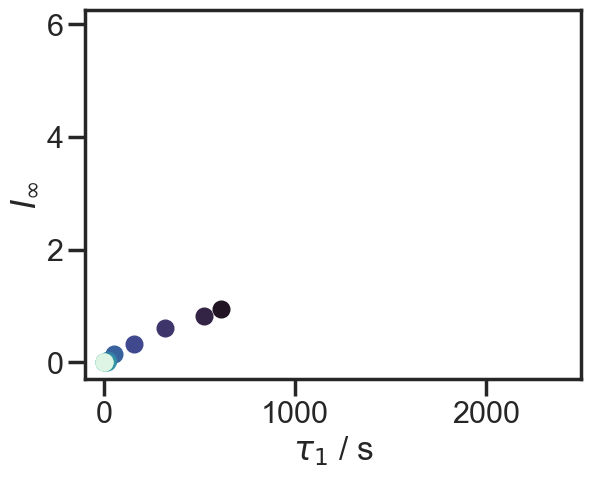

In [22]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(temp_fit.x[0], temp_fit.x[1], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel(r'$\tau_1$ / s')
plt.ylabel(r'$I_\infty$')

plt.xlim([-100, 2500])

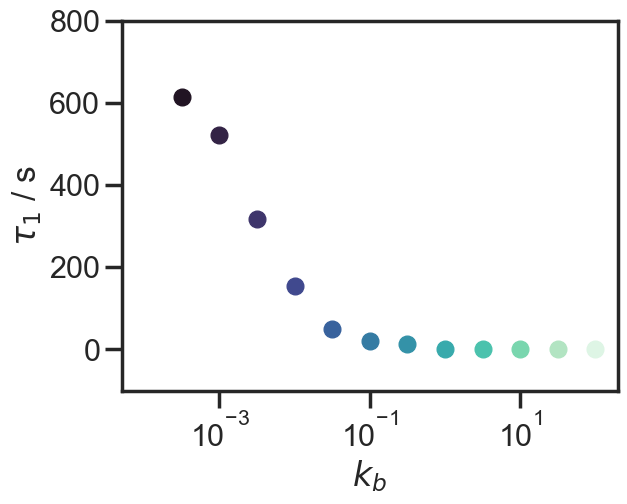

In [23]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(kbleach, temp_fit.x[0], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.ylabel(r'$\tau_1$ / s')
plt.xlabel(r'$k_b$')

plt.ylim(-100, 800)

plt.xscale('log')

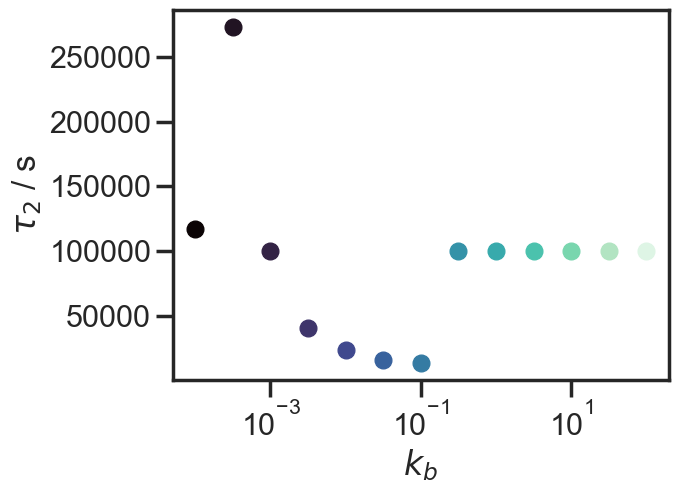

In [24]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(kbleach, temp_fit.x[-1], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.ylabel(r'$\tau_2$ / s')
plt.xlabel(r'$k_b$')

plt.xscale('log')

# plt.ylim(-100, 800)

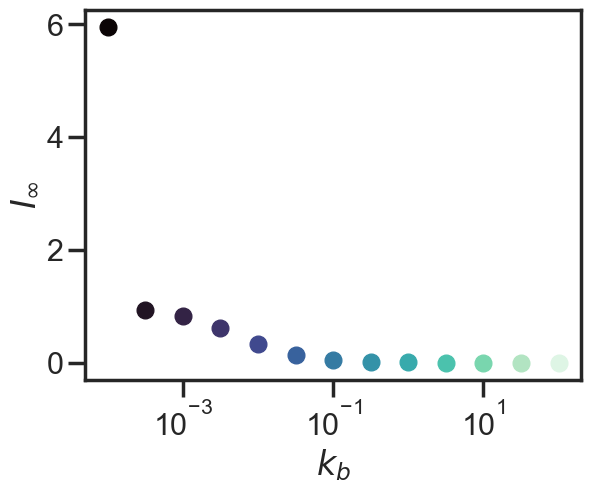

In [25]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(kbleach, temp_fit.x[1], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.ylabel(r'$I_\infty$')
plt.xlabel(r'$k_b$')

plt.xscale('log')

# plt.ylim(-100, 800)

## `20250416` - plot CDF of Poisson

In [8]:
import math

In [19]:
def poissonDistPMF(l, k):
    return l**k * np.exp(-l)/math.factorial(k)

def poissonDistCDFcomplement(l, k):
    return 1-np.sum([poissonDistPMF(l, j) for j in range(0,k+1)])

In [20]:
poissonDistCDFcomplement(1, 4)

np.float64(0.00365984682734366)

In [21]:
aVals=np.array([0, 1, 5, 25, 5**3, 5**4, 5**5, 5**6])
l=200; # photons per probe per (20s) pulse

plt.plot(aVals, [poissonDistCDFcomplement(l, a) for a in aVals], 'm-')

OverflowError: int too large to convert to float

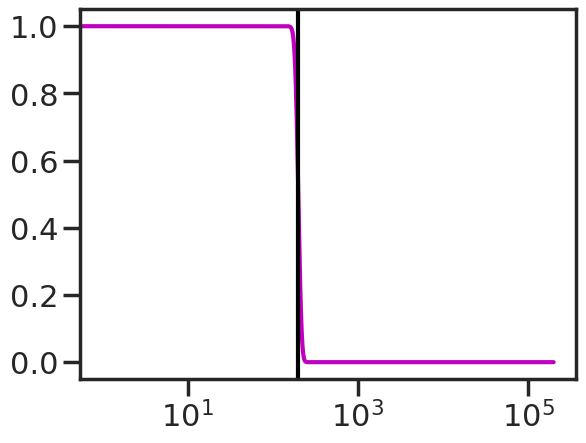

In [35]:
aVals=np.arange(0, 2*10**5, 1)
## succumb to the hegemony of scipy

plt.plot(aVals, 1-scipy.stats.poisson.cdf(aVals, l), 'm-')
plt.xscale('log')
plt.axvline(x=200, color='k')

In [37]:
1-scipy.stats.poisson.cdf(10**5, 200)

np.float64(0.0)

# needs no date - Still in the same notebook to placate Gabriel. 

# 20250416 - Parameter sweep in $k_b$ and $D$ in comsol :o

In [297]:
#yes, ana is meAN
#aname = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250416ParamSweepKbDAvg.csv'
#aname = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250416ParamSweepKbDAvg_take2.csv'
aname1 = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250416ParamSweepKbDAvg_um2persUnits.csv'
aname2 = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250416ParamSweepKbDAvg_um2persUnits_kb0.01-1.csv'
aname3 = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250416ParamSweepKbDAvg_um2persUnits_D4000.csv'
anames = [aname1, aname2, aname3]

raw2dSweep=pd.concat([pd.read_csv(aname, header=4) for aname in anames])
raw2dSweep['kbleach (1/s)']=raw2dSweep['% kbleach (1/s)']
raw2dSweep['u (uM)'] = raw2dSweep['Dependent variable u (mol/m^3)']*10**3 #convert mol/m^3 to uM
raw2dSweep=raw2dSweep[['kbleach (1/s)', 'D (um^2/s)', 'Time (s)', 'u (uM)']]
raw2dSweep['conditionTuple_kb_D']=raw2dSweep.apply(lambda row: (row['kbleach (1/s)'], row['D (um^2/s)']), axis=1)
raw2dSweep

kbleach (1/s)  D (um^2/s)  Time (s)    u (uM)        conditionTuple_kb_D
0             0.001         4.0         0  2.999941               (0.001, 4.0)
1             0.001         4.0        50  2.869872               (0.001, 4.0)
2             0.001         4.0       100  2.757655               (0.001, 4.0)
3             0.001         4.0       150  2.655982               (0.001, 4.0)
4             0.001         4.0       200  2.579850               (0.001, 4.0)
...             ...         ...       ...       ...                        ...
1000         10.000      4000.0      9800  0.003875  (10.0, 4000.000000000001)
1001         10.000      4000.0      9850  0.003815  (10.0, 4000.000000000001)
1002         10.000      4000.0      9900  0.003756  (10.0, 4000.000000000001)
1003         10.000      4000.0      9950  0.003698  (10.0, 4000.000000000001)
1004         10.000      4000.0     10000  0.003641  (10.0, 4000.000000000001)

[4020 rows x 5 columns]

In [298]:
grouped=raw2dSweep.groupby('conditionTuple_kb_D').apply(lambda row: (row['Time (s)'].values, row['u (uM)'].values))
grouped

conditionTuple_kb_D
(0.001, 4.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 40.0)                 ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 400.0)                ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 4000.000000000001)    ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 4.0)                   ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 40.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 400.0)                 ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 4000.000000000001)     ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 4.0)                    ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 40.0)                   ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 400.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 4000.000000000001)      ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(1.0, 4.0)          

In [299]:
sortTupleByFirstEntries = lambda pair: (pair[0][np.argsort(pair[0])], pair[-1][np.argsort(pair[0])])

In [300]:
def sortTupleByFirstEntries(pair):
    return (pair[0][np.argsort(pair[0])], 
            pair[-1][np.argsort(pair[0])])

In [301]:
# unit test
#sortTupleByFirstEntries((np.array([2,1,3,4]), np.array([3,2,1,4])))

In [302]:
grouped=grouped.apply(sortTupleByFirstEntries)
grouped

conditionTuple_kb_D
(0.001, 4.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 40.0)                 ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 400.0)                ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.001, 4000.000000000001)    ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 4.0)                   ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 40.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 400.0)                 ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.01, 4000.000000000001)     ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 4.0)                    ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 40.0)                   ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 400.0)                  ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(0.1, 4000.000000000001)      ([0, 50, 100, 150, 200, 250, 300, 350, 400, 45...
(1.0, 4.0)          

In [303]:
raw2dSweep['conditionTuple_kb_D']

0                    (0.001, 4.0)
1                    (0.001, 4.0)
2                    (0.001, 4.0)
3                    (0.001, 4.0)
4                    (0.001, 4.0)
                  ...            
1000    (10.0, 4000.000000000001)
1001    (10.0, 4000.000000000001)
1002    (10.0, 4000.000000000001)
1003    (10.0, 4000.000000000001)
1004    (10.0, 4000.000000000001)
Name: conditionTuple_kb_D, Length: 4020, dtype: object

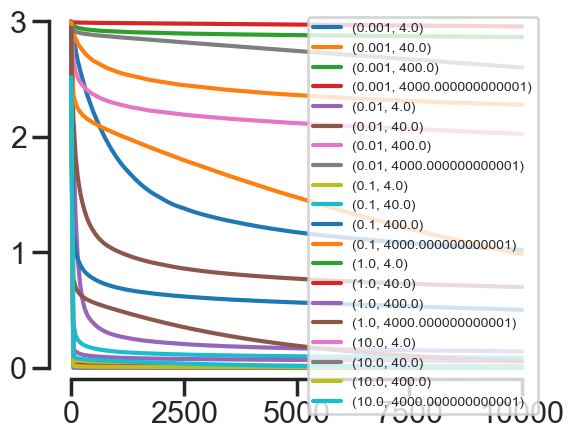

In [304]:
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
for opt in np.unique(raw2dSweep['conditionTuple_kb_D']):
    ax.plot(grouped[opt][0], grouped[opt][1], label=str(opt))
#ax.plot(*grouped[(0.01, 40.0)], 'b-', label='0.01')

ax.set_ylim([-0.1, 3.1])
plt.legend(fontsize=10)
sns.despine(trim=True)

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

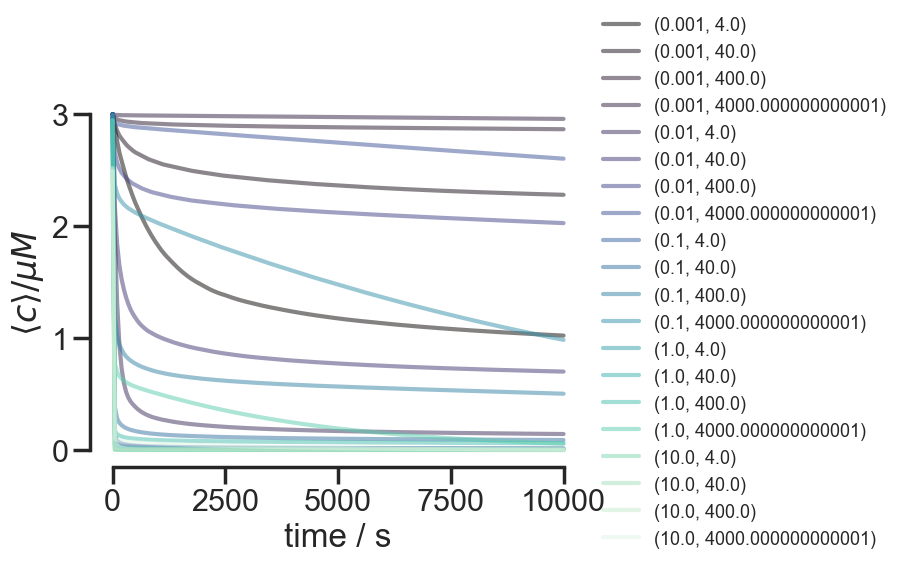

In [305]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(np.unique(raw2dSweep['conditionTuple_kb_D'])))]

for ii, opt in enumerate(np.unique(raw2dSweep['conditionTuple_kb_D'])):
    plt.plot(grouped[opt][0], 
             grouped[opt][1], color=colorList[ii],
             alpha=0.5,
            label=str(opt))

sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

# Plot all the comsol curves and their fits organized by D and kb

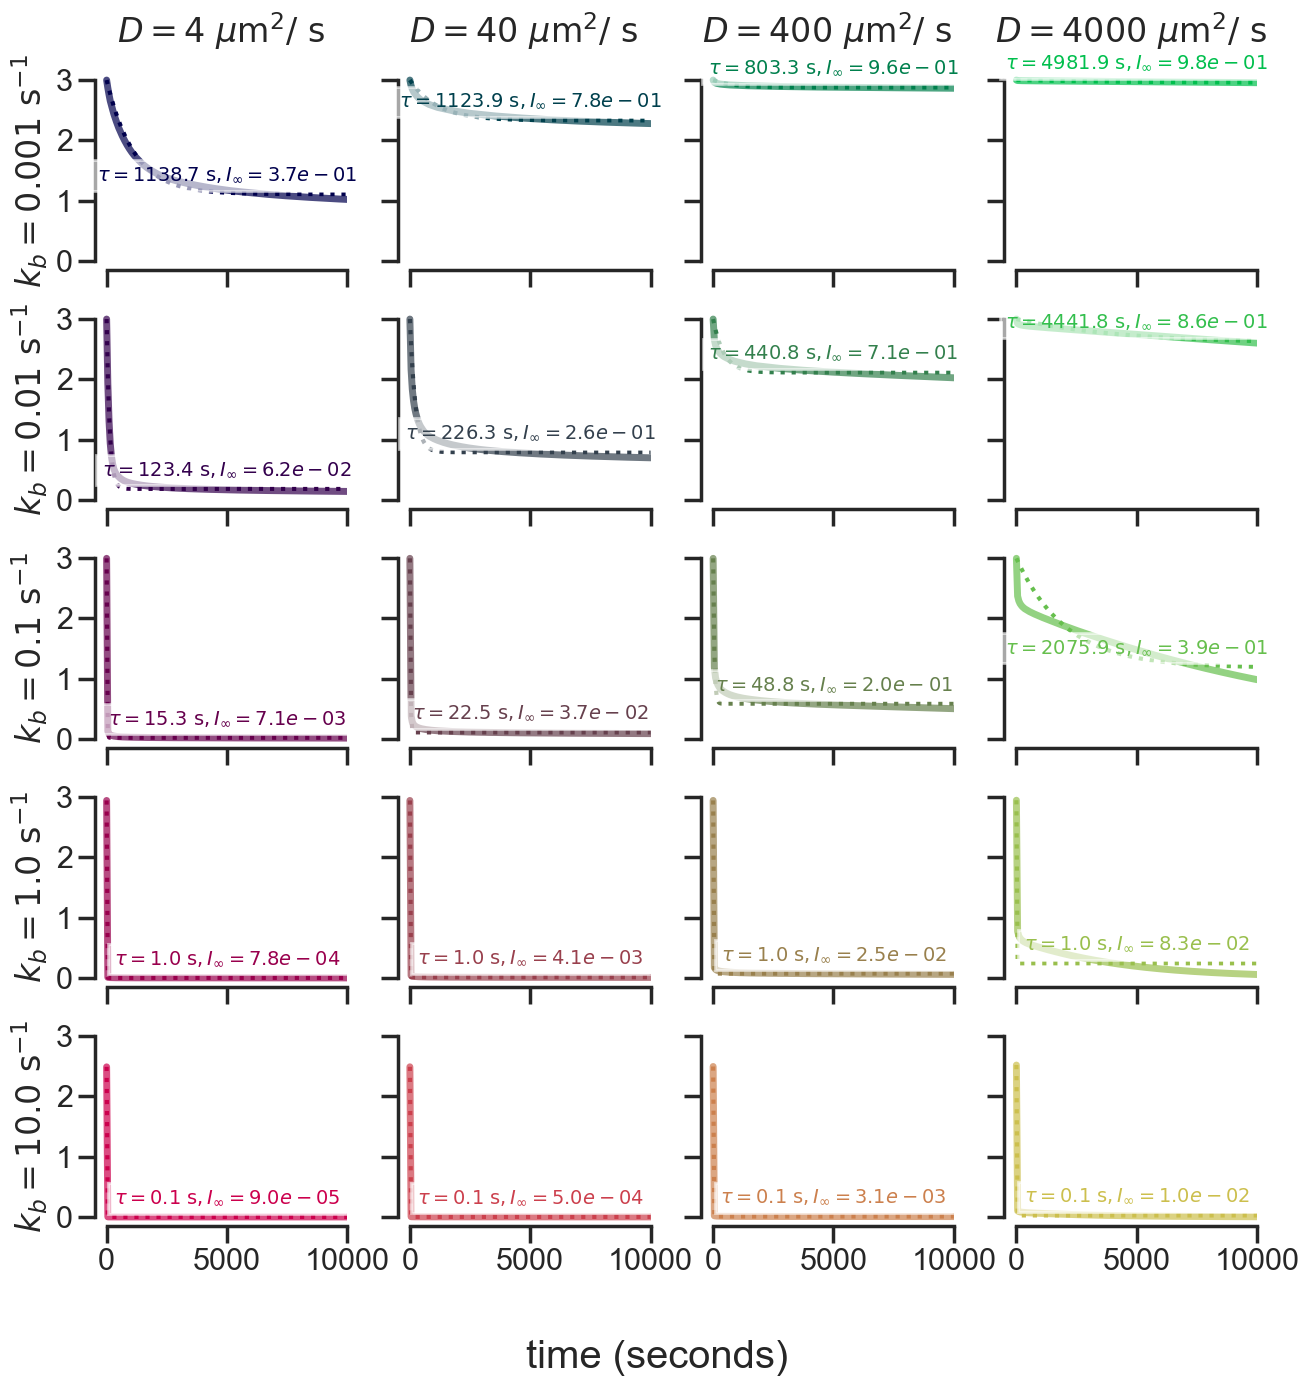

In [487]:
#x axis limits
istart = 0
tstop = grouped[(uniquekbvals[ii], uniqueDvals[j])][0].max()
istop= tstop//(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][1]-grouped[(uniquekbvals[ii], uniqueDvals[j])][0][0])

#unique parameter sweep values
uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])

#instantiate figure
fig, axs=plt.subplots(len(uniquekbvals), len(uniqueDvals), figsize=(15,15), sharex=True, sharey=True)

#loop through parameters
for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        
        #plot the comsol data
        axs[ii,j].plot(*grouped[(uniquekbvals[ii], uniqueDvals[j])], 
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 0.7), 
                       ls='-', lw=5
                       )
        
        # plot fit too - set fit to x axis limits
        temp_fit = singExpConstFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop].max(),
                                        (1/uniquekbvals[ii], 0.75))
        axs[ii,j].plot(grouped[(uniquekbvals[ii], uniqueDvals[j])][0], 
             singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(), ':', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        # label fit results in plot
        fitString=r'$\tau ='+str(round(temp_fit.x[0], 1))+'~\mathrm{s}, I_\infty = '+'{:.1e}'.format(round(temp_fit.x[-1],5))+'$'
        axs[ii,j].text(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop][(istart+istop)//2],#[-90],
                       (singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max())[-1]+0.15,
                       fitString,
                      ha='center',
                      va='bottom',
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 1),
                      fontsize=14,
                      bbox=dict(facecolor='white', alpha=0.6))
        
        
        # labels
        axs[0,j].set_title(r'$D = '+str(round(uniqueDvals[j]))+'~\mu \mathrm{m}^2/~\mathrm{s}$', y=1.1)

    axs[ii,0].set_ylabel(r'$k_b = '+str(uniquekbvals[ii])+'~\mathrm{s}^{-1}$')

#configure axis
axs[0][0].set_xlim(-0.05*tstop,tstop)
axs[0][0].set_xticks(np.arange(0, tstop+tstop/2, tstop/2))#, minor=True)
axs[0][0].set_yticks(np.arange(0, 4, 1))
fig.supxlabel('time (seconds)')
#stylish
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250417_SmMultDvskbSingExpConst.pdf", bbox_inches='tight', transparent=True)

## Crop fit to 4000 seconds

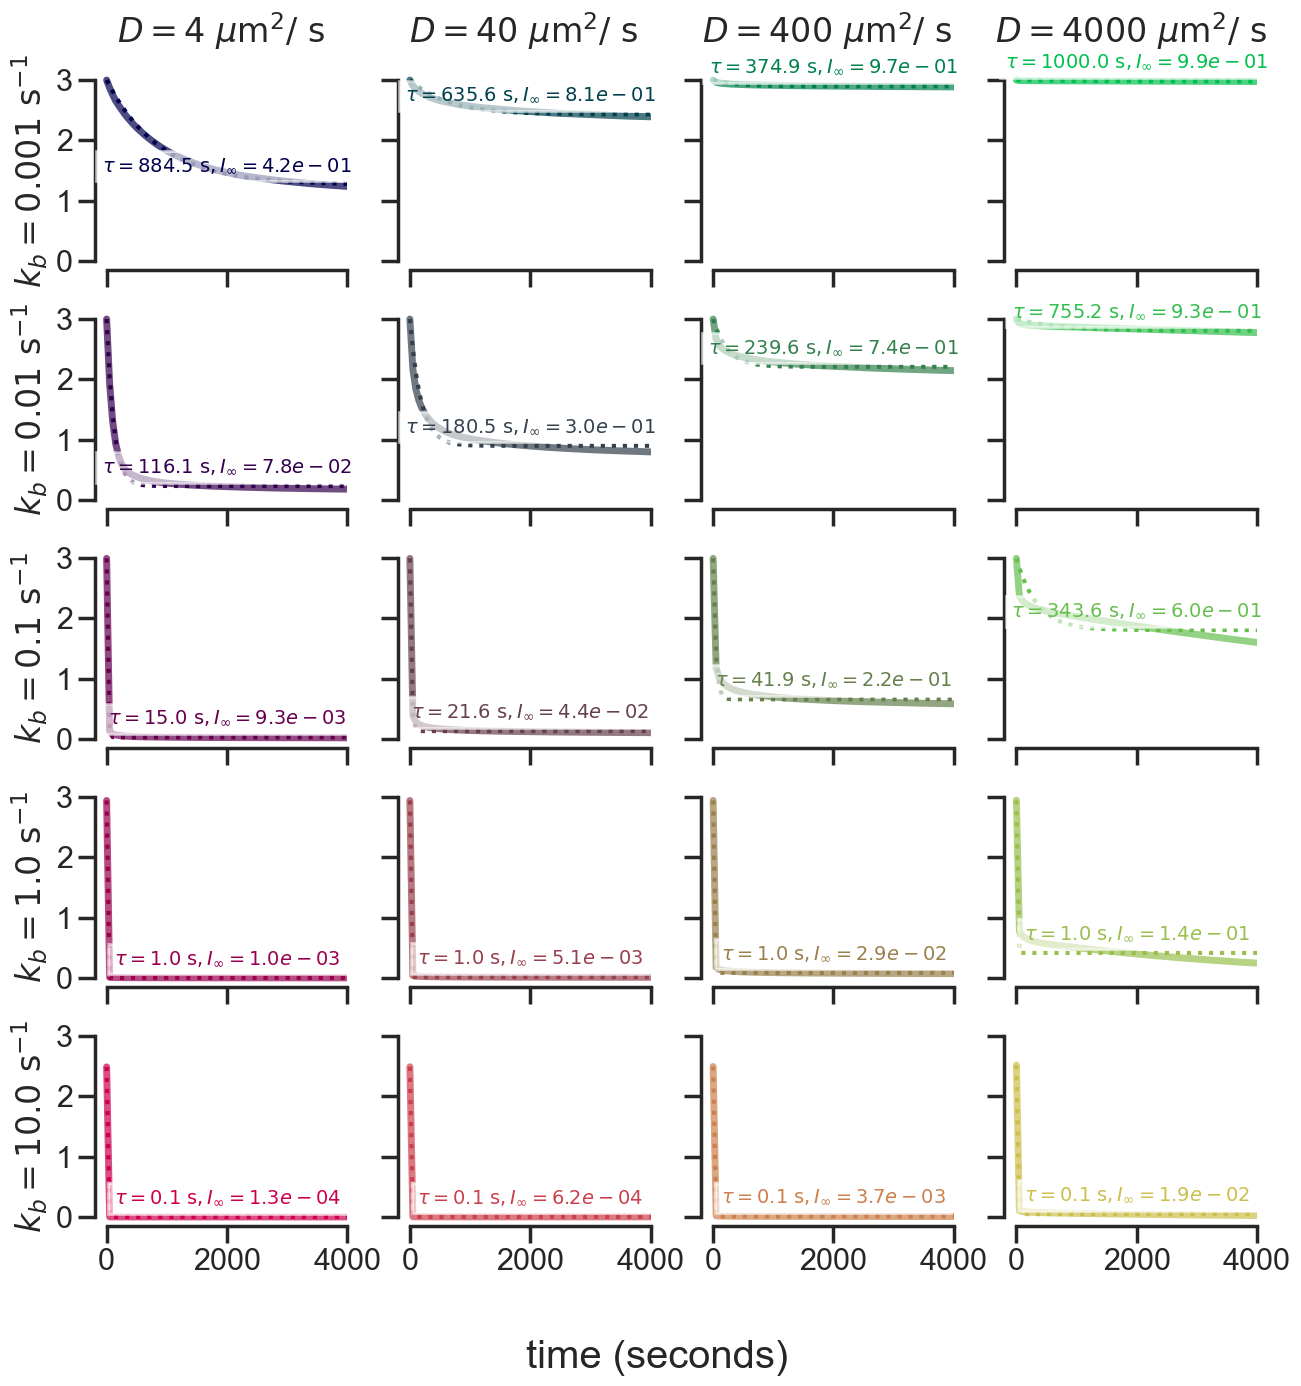

In [488]:
#x axis limits
istart = 0
tstop = 4000
istop= tstop//(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][1]-grouped[(uniquekbvals[ii], uniqueDvals[j])][0][0])

#unique parameter sweep values
uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])

#instantiate figure
fig, axs=plt.subplots(len(uniquekbvals), len(uniqueDvals), figsize=(15,15), sharex=True, sharey=True)

#loop through parameters
for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        
        #plot the comsol data
        axs[ii,j].plot(*grouped[(uniquekbvals[ii], uniqueDvals[j])], 
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 0.7), 
                       ls='-', lw=5
                       )
        
        # plot fit too - set fit to x axis limits
        temp_fit = singExpConstFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop].max(),
                                        (1/uniquekbvals[ii], 0.75))
        axs[ii,j].plot(grouped[(uniquekbvals[ii], uniqueDvals[j])][0], 
             singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(), ':', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        # label fit results in plot
        fitString=r'$\tau ='+str(round(temp_fit.x[0], 1))+'~\mathrm{s}, I_\infty = '+'{:.1e}'.format(round(temp_fit.x[-1],5))+'$'
        axs[ii,j].text(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop][(istart+istop)//2],#[-90],
                       (singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max())[-1]+0.15,
                       fitString,
                      ha='center',
                      va='bottom',
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 1),
                      fontsize=14,
                      bbox=dict(facecolor='white', alpha=0.6))
        
        
        # labels
        axs[0,j].set_title(r'$D = '+str(round(uniqueDvals[j]))+'~\mu \mathrm{m}^2/~\mathrm{s}$', y=1.1)

    axs[ii,0].set_ylabel(r'$k_b = '+str(uniquekbvals[ii])+'~\mathrm{s}^{-1}$')

    
#configure axis
axs[0][0].set_xlim(-0.05*tstop,tstop)
axs[0][0].set_xticks(np.arange(0, tstop+tstop/2, tstop/2))#, minor=True)
axs[0][0].set_yticks(np.arange(0, 4, 1))
fig.supxlabel('time (seconds)')
#stylish
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250417_SmMultDvskbSingExpConst4000sfit.pdf", bbox_inches='tight', transparent=True)

## Show change in kb for each D

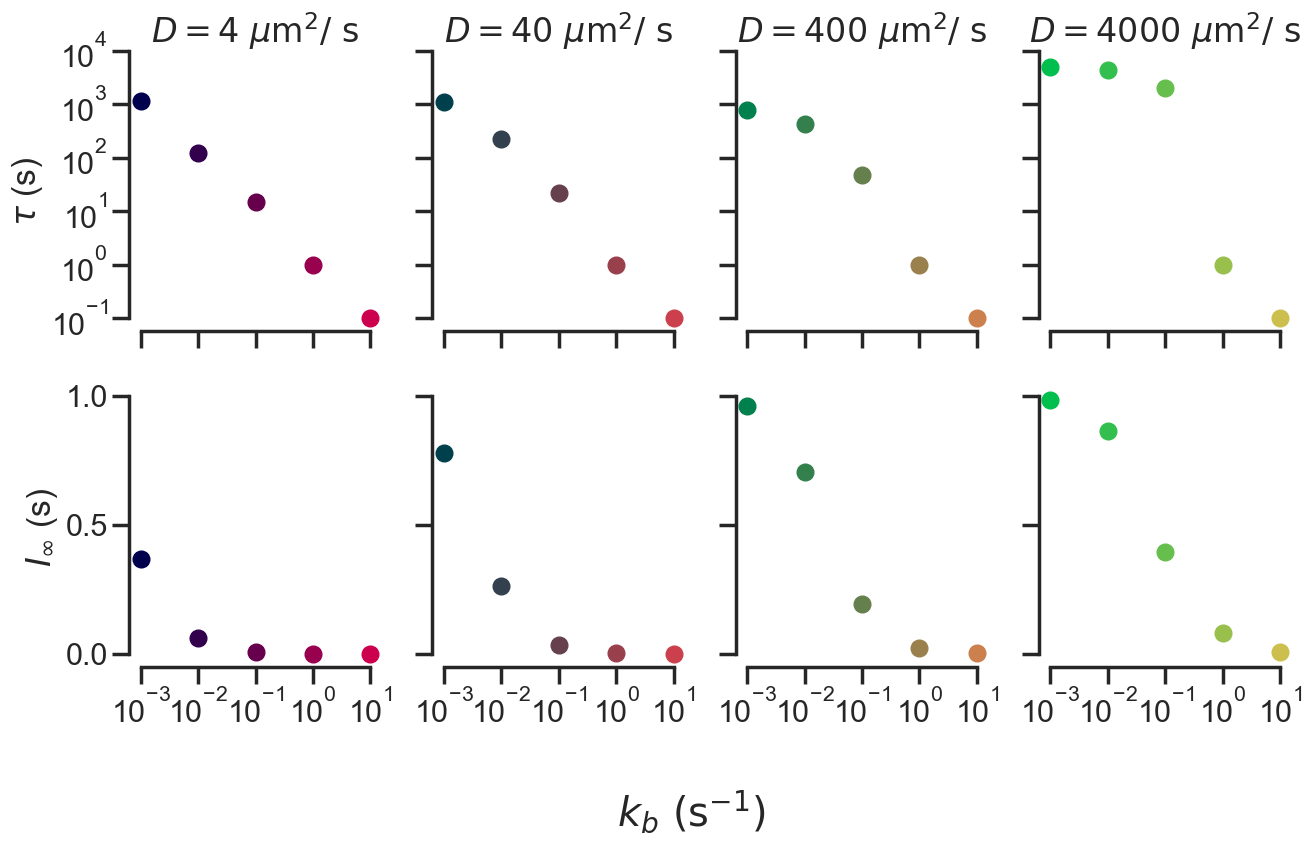

In [489]:
#x axis limits
istart = 0
tstop = grouped[(uniquekbvals[ii], uniqueDvals[j])][0].max()
istop= tstop//(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][1]-grouped[(uniquekbvals[ii], uniqueDvals[j])][0][0])


## PLOT fit parameter values!

uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])


fig, axs=plt.subplots(2, len(uniqueDvals), figsize=(15,8), sharex=True, sharey='row')

for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        

        # plot fit too
        temp_fit = singExpConstFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(),
                                        (1/uniquekbvals[ii], 0.75))
        axs[0][j].plot(uniquekbvals[ii], temp_fit.x[0],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        axs[1][j].plot(uniquekbvals[ii], temp_fit.x[1],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        
        # labels
        axs[0][j].set_title(r'$D = '+str(round(uniqueDvals[j]))+'~\mu \mathrm{m}^2/~\mathrm{s}$')

        axs[0][j].set_yscale('log')
        # axs[1][j].set_yscale('log')
        axs[0][j].set_xscale('log')
        axs[1][j].set_xscale('log')
fig.supxlabel(r'$k_b~(\mathrm{s}^{-1})$', y=-0.1)
axs[0][0].set_ylabel(r'$\tau$ (s)')
axs[1][0].set_ylabel(r'$I_\infty$ (s)')
axs[0][0].set_xticks(np.logspace(np.log10(uniquekbvals.min()), np.log10(uniquekbvals.max()), len(uniquekbvals)))#, minor=True)
axs[0][0].set_yticks(np.logspace(-1, 4, 6))#, minor=True)

#axs[0][0].set_yticks(np.arange(0, 4, 1))
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250417_FitParamsSingExpConstconstDvarykb10000sfit.pdf", bbox_inches='tight', transparent=True)

## Show change in D for each kb

Text(0.5, 1.0, '$I_\\infty$')

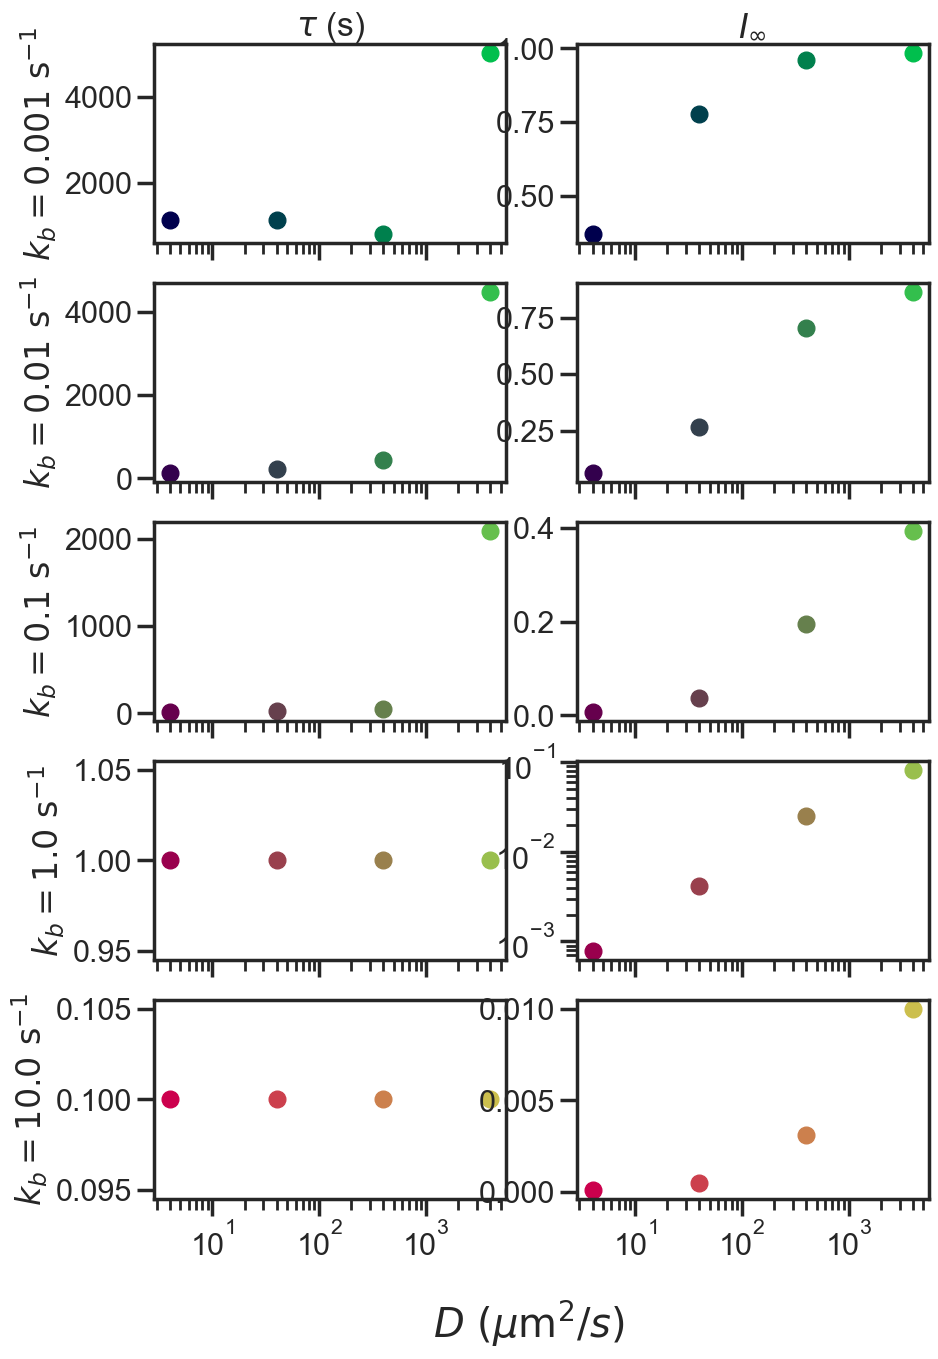

In [322]:
## PLOT fit parameter values!

uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])


fig, axs=plt.subplots(len(uniquekbvals), 2, figsize=(10,15), sharex=True, )#sharey=True)

for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        

        # plot fit too
        temp_fit = singExpConstFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(),
                                        (1/uniquekbvals[ii], 0.75))
        axs[ii][0].plot(uniqueDvals[j], temp_fit.x[0],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        axs[ii][1].plot(uniqueDvals[j], temp_fit.x[1],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        # # label fit results in plot
        # fitString=r'$\tau ='+str(round(temp_fit.x[0], 5))+', I_\infty = '+str(round(temp_fit.x[-1],5))+'$'
        # axs[ii,j].text(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][-90],
        #                (singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max())[-1]+0.15,
        #                fitString,
        #               ha='center',
        #               va='bottom',
        #               color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 1),
        #               fontsize=14,
        #               bbox=dict(facecolor='white', alpha=0.6))
        
        
        # labels
        #axs[j].set_title(r'$D = '+str(uniqueDvals[j])+'~\mu \mathrm{m}^2/~\mathrm{s}$')
        
    axs[ii][0].set_ylabel(r'$k_b = '+str(uniquekbvals[ii])+'~\mathrm{s}^{-1}$')
        
axs[j][1].set_yscale('log')
axs[j][1].set_xscale('log')
fig.supxlabel(r'$D ~ (\mu \mathrm{m}^2/s)$')
axs[0][0].set_title(r'$\tau$ (s)')
axs[0][1].set_title(r'$I_\infty$')
#sns.despine(trim=True)



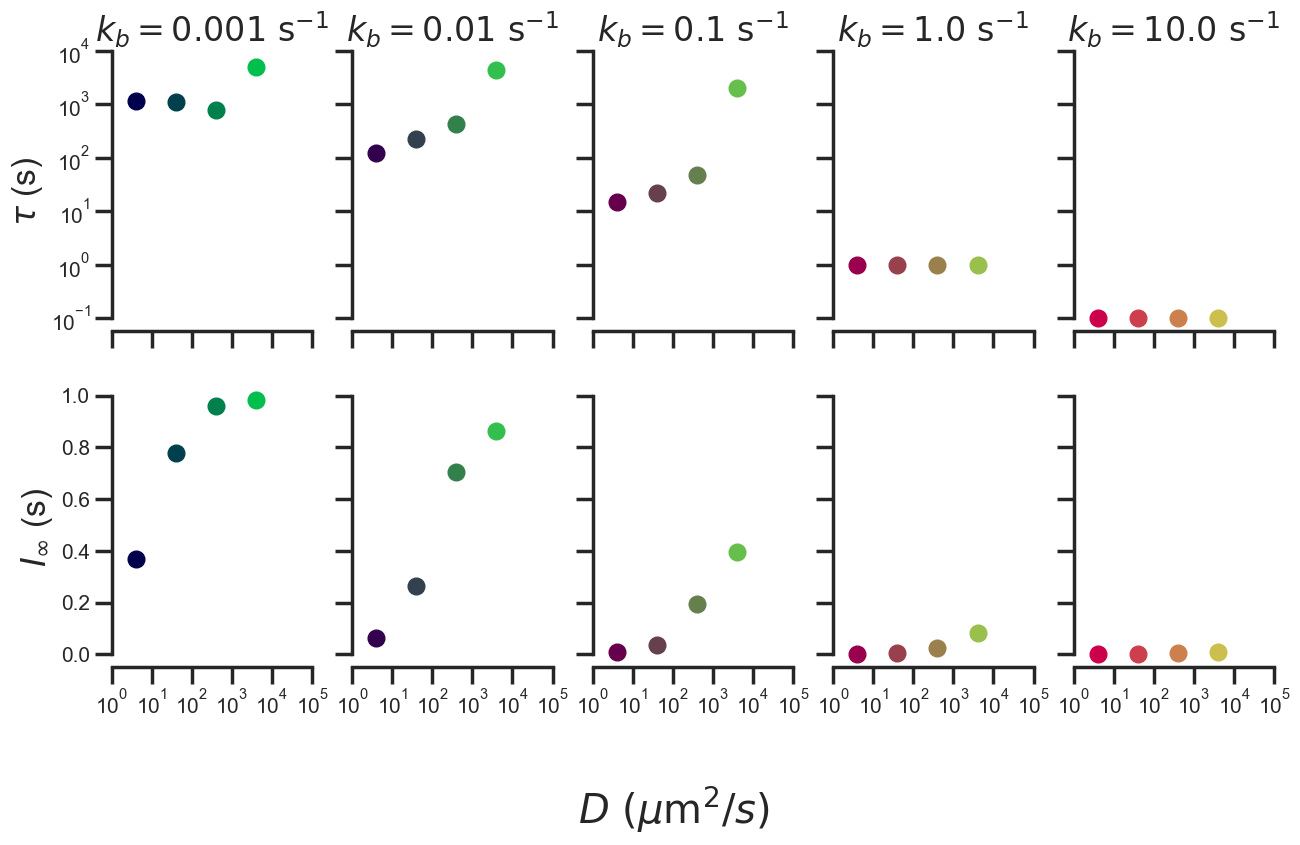

In [490]:
#x axis limits
istart = 0
tstop = grouped[(uniquekbvals[ii], uniqueDvals[j])][0].max()
istop= tstop//(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][1]-grouped[(uniquekbvals[ii], uniqueDvals[j])][0][0])


## PLOT fit parameter values!

uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])


fig, axs=plt.subplots(2, len(uniquekbvals), figsize=(15,8), sharex=True, sharey='row')

for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        

        # plot fit too
        temp_fit = singExpConstFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(),
                                        (1/uniquekbvals[ii], 0.75))
        axs[0][ii].plot(uniqueDvals[j], temp_fit.x[0],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        axs[1][ii].plot(uniqueDvals[j], temp_fit.x[1],
             'o', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        
        # labels
        axs[0][ii].set_title(r'$k_b = '+str(uniquekbvals[ii])+'~\mathrm{s^{-1}}$')
        axs[0][ii].tick_params(labelsize=15)
        axs[1][ii].tick_params(labelsize=15)

axs[0][0].set_xscale('log')
axs[0][0].set_yscale('log')
fig.supxlabel(r'$D ~ (\mu \mathrm{m}^2/s)$', y=-0.1)
axs[0][0].set_ylabel(r'$\tau$ (s)')
axs[1][0].set_ylabel(r'$I_\infty$ (s)')
axs[0][0].set_xticks(np.logspace(0, 5, 6))#, minor=True)
#axs[0][0].set_xticks(np.logspace(np.log10(4), np.log10(4000), 4))#, minor=True)
axs[0][0].set_yticks(np.logspace(-1, 4, 6))#, minor=True)

#axs[0][0].set_yticks(np.arange(0, 4, 1))
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250417_FitParamsSingExpConstconstkbvaryD10000sfit.pdf", bbox_inches='tight', transparent=True)

## Fit to a double exponential

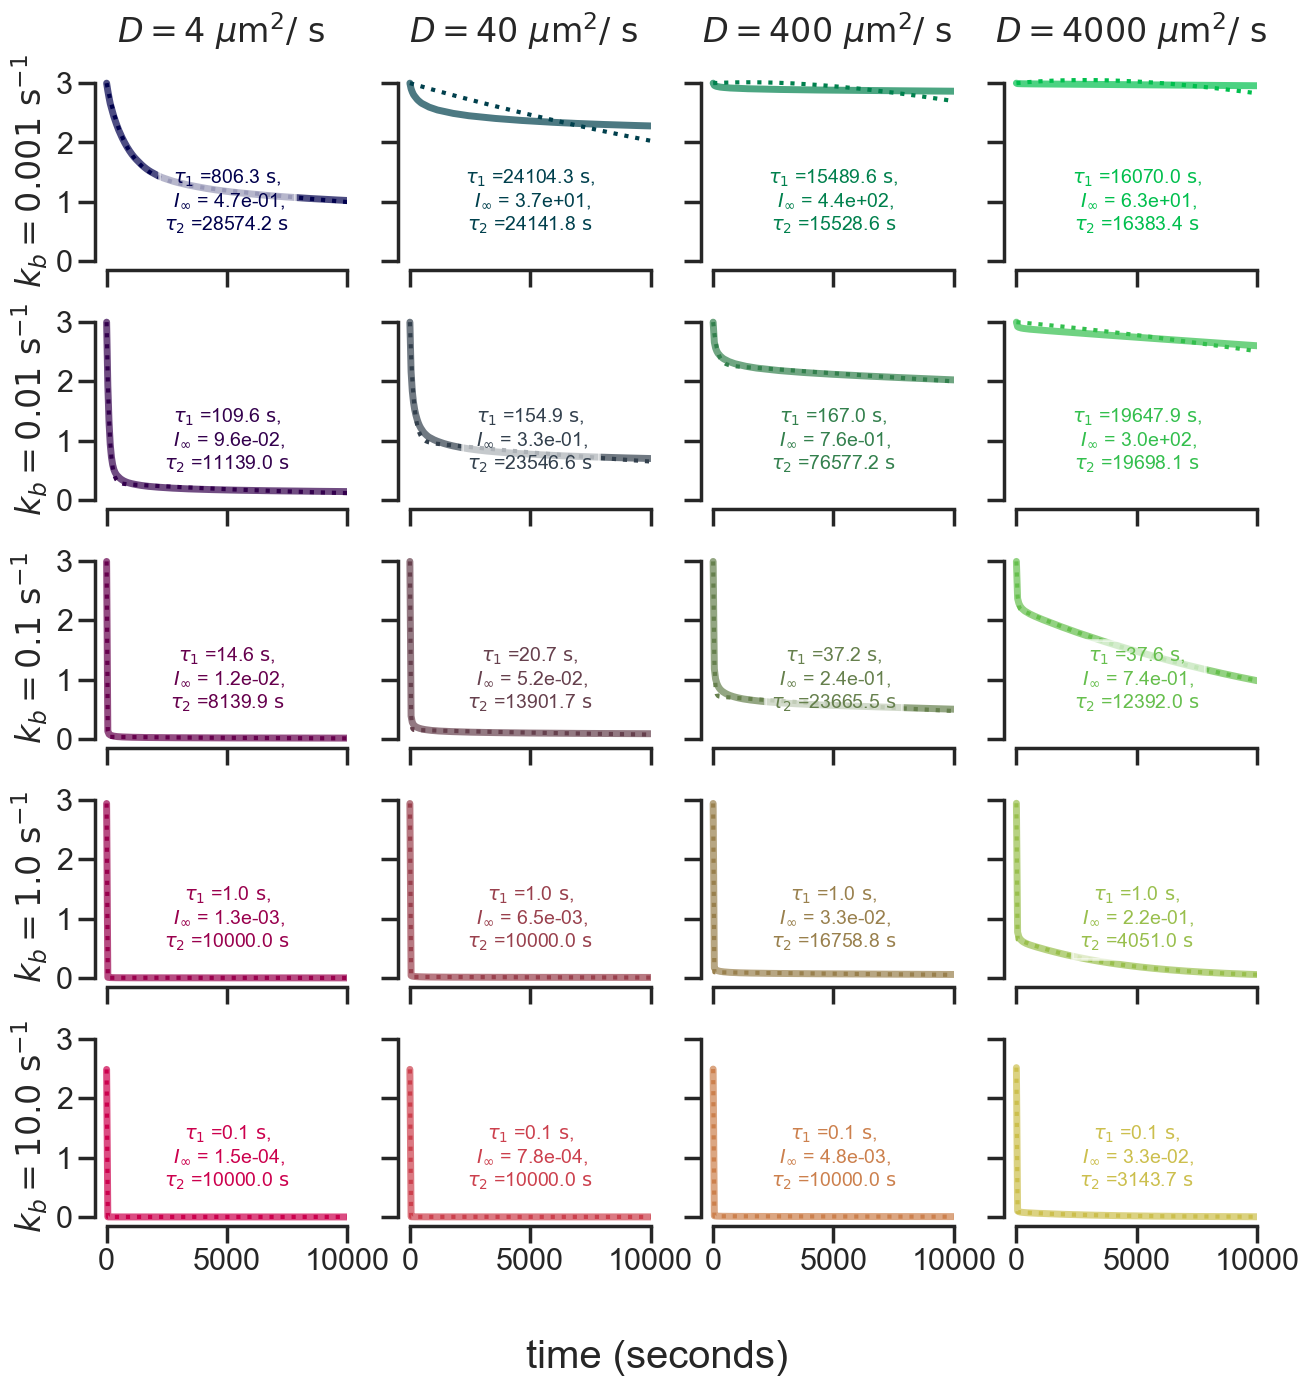

In [493]:
#x axis limits
istart = 0
tstop = grouped[(uniquekbvals[ii], uniqueDvals[j])][0].max()
istop= tstop//(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][1]-grouped[(uniquekbvals[ii], uniqueDvals[j])][0][0])

#unique parameter sweep values
uniquekbvals=np.unique(raw2dSweep['kbleach (1/s)'])
uniqueDvals=np.unique(raw2dSweep['D (um^2/s)'])

#instantiate figure
fig, axs=plt.subplots(len(uniquekbvals), len(uniqueDvals), figsize=(15,15), sharex=True, sharey=True)

#loop through parameters
for ii in range(len(uniquekbvals)):
    for j in range(len(uniqueDvals)):
        
        #plot the comsol data
        axs[ii,j].plot(*grouped[(uniquekbvals[ii], uniqueDvals[j])], 
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 0.7), 
                       ls='-', lw=5
                       )
        
        # plot fit too - set fit to x axis limits
        temp_fit = doubExpFit_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop],
                                        grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop]/grouped[(uniquekbvals[ii], uniqueDvals[j])][1][istart:istop].max(),
                                        (1/uniquekbvals[ii], 0.75, 10000))
        axs[ii,j].plot(grouped[(uniquekbvals[ii], uniqueDvals[j])][0], 
             doubExp_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max(), ':', color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3))
        
        # label fit results in plot
        fitString=r'$\tau_1$ ='+str(round(temp_fit.x[0], 1))+'$~\mathrm{s}$,\n $I_\infty$ = '+'{:.1e}'.format(round(temp_fit.x[1],5))+', \n'+r'$\tau_2$ ='+str(round(temp_fit.x[2], 1))+'$~\mathrm{s}$'
        #fitString='shock size \n $n-n_{fd}$'
        axs[ii,j].text(grouped[(uniquekbvals[ii], uniqueDvals[j])][0][istart:istop][(istart+istop)//2],#[-90],
                       1,#(singExpConst_max1(grouped[(uniquekbvals[ii], uniqueDvals[j])][0],temp_fit.x)*grouped[(uniquekbvals[ii], uniqueDvals[j])][1].max())[1]+0.15,
                       fitString,
                      ha='center',
                      va='center',
                      color=(ii/len(uniquekbvals), j/len(uniqueDvals), 0.3, 1),
                      fontsize=14,
                      bbox=dict(facecolor='white', alpha=0.6))
        
        
        # labels
        axs[0,j].set_title(r'$D = '+str(round(uniqueDvals[j]))+'~\mu \mathrm{m}^2/~\mathrm{s}$', y=1.1)

    axs[ii,0].set_ylabel(r'$k_b = '+str(uniquekbvals[ii])+'~\mathrm{s}^{-1}$')

#configure axis
axs[0][0].set_xlim(-0.05*tstop,tstop)
axs[0][0].set_xticks(np.arange(0, tstop+tstop/2, tstop/2))#, minor=True)
axs[0][0].set_yticks(np.arange(0, 4, 1))
fig.supxlabel('time (seconds)')
#stylish
sns.despine(trim=True)

(2400.0, 2520.0)

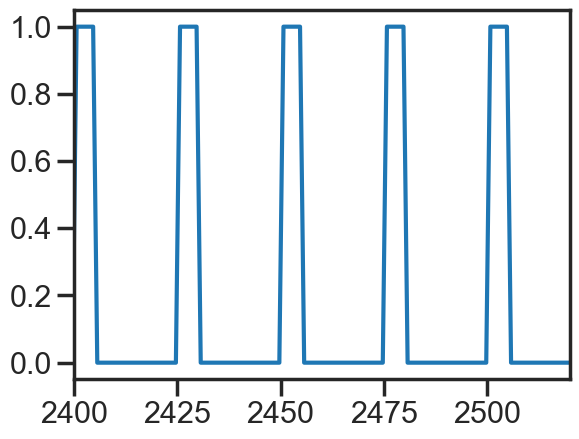

In [507]:
#pulsedir = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250418_pulse150ms.csv'
pulsedir = '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250418_pulse5s.csv'
pulsedata = pd.read_csv(pulsedir, header=7)
plt.plot(pulsedata['% t'], pulsedata['an1(t)'])
plt.xlim(2400, 2520)

# test pulse process in comsol 

$$\frac{\partial c}{\partial t} = -k c$$
$$c(t+\Delta t) = c(t) - k(t)*c$$
$$k(t) = \mathscr{k} \frac{1+\text{sign}( \sin(\pi t))}{2}$$

Text(0.5, 0, 't')

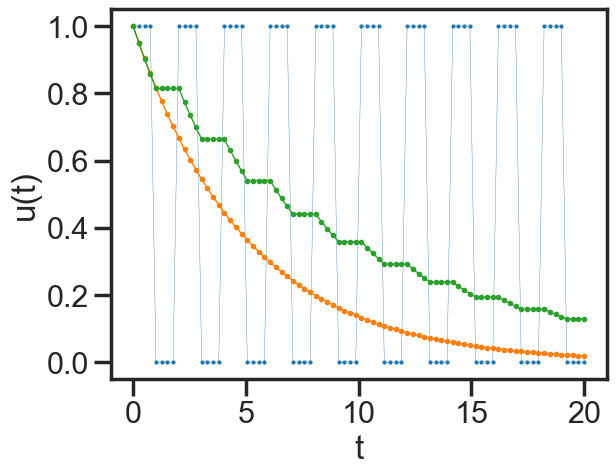

In [60]:
# define a pulse function
teststep=0.25
teststart=0
testend = 20
testk = 1/5 #s^-1
testtimes = np.linspace(teststart, testend, int((testend-teststart)/teststep))
teststepftn = (1+np.sign(np.cos(testtimes*np.pi-np.pi/2)))/2 #-np.pi/2 so that firt 4 points all start at 1 (sin(0) puts it at 0.5)

testc0=1
testintegral = np.zeros_like(testtimes)
testintegral[0]=testc0
for t in range(len(testtimes)-1):
    testintegral[t+1] = testintegral[t]*(1 - testk*teststepftn[t]*teststep)

plt.plot(testtimes, teststepftn, marker='o', ms=2, lw=0.25)
plt.plot(testtimes, np.exp(-testk*testtimes), marker='o',ms=3, lw=1)
plt.plot(testtimes, testintegral, marker='o', ms=3, lw=1)

plt.ylabel('u(t)')
plt.xlabel('t')


In [12]:
np.linspace(0, 20, 80)

array([ 0.        ,  0.25316456,  0.50632911,  0.75949367,  1.01265823,
        1.26582278,  1.51898734,  1.7721519 ,  2.02531646,  2.27848101,
        2.53164557,  2.78481013,  3.03797468,  3.29113924,  3.5443038 ,
        3.79746835,  4.05063291,  4.30379747,  4.55696203,  4.81012658,
        5.06329114,  5.3164557 ,  5.56962025,  5.82278481,  6.07594937,
        6.32911392,  6.58227848,  6.83544304,  7.08860759,  7.34177215,
        7.59493671,  7.84810127,  8.10126582,  8.35443038,  8.60759494,
        8.86075949,  9.11392405,  9.36708861,  9.62025316,  9.87341772,
       10.12658228, 10.37974684, 10.63291139, 10.88607595, 11.13924051,
       11.39240506, 11.64556962, 11.89873418, 12.15189873, 12.40506329,
       12.65822785, 12.91139241, 13.16455696, 13.41772152, 13.67088608,
       13.92405063, 14.17721519, 14.43037975, 14.6835443 , 14.93670886,
       15.18987342, 15.44303797, 15.69620253, 15.94936709, 16.20253165,
       16.4556962 , 16.70886076, 16.96202532, 17.21518987, 17.46

Treat the pulses as a sin(t) wave so that we can get an analytic solution. Let us define the pulsing function as
$$f(t) = \frac{1}{2}+ \frac{1}{2} \sin \left(\frac{2\pi t}{t_\text{int}}\right),$$
where $t_\text{int}$ is the pulsing interval. Then, we define the PDE for the intensity decay due to photobleaching as 
$$\frac{\partial u}{\partial t} = -ku(t)f(t) = -\frac{ku}{2}\left(1+  \sin \left(\frac{2\pi t}{t_\text{int}}\right) \right). $$
Separating variables, we can integrate and find the analytical solution. 
$$\int_{u(0)}^{u(t)} \frac{\text{d}u(t')}{u(t')} = \int_0^t -\frac{k}{2} \text{d}t' + \int_0^t -\frac{k}{2} \sin\left(\frac{2\pi t'}{t_\text{int}}\right)\text{d}t'$$
$$\ln\left(\frac{u(t)}{u(0)}\right) = -\frac{k}{2}t + \frac{k t_\text{int}}{4\pi}\left(\cos\left( \frac{2\pi t'}{t_\text{int}}\right)-1\right)$$
Exponentiating both sides we find the analytical solution,
$$\boxed{u(t) = u(0)\exp\left(-\frac{k}{2}t + \frac{k t_\text{int}}{4\pi}\left(\cos\left( \frac{2\pi t'}{t_\text{int}}\right)-1\right) \right)}$$

We can compare the analytic solution against a discrete solution,
$$u(t+\Delta t) = u(t) - \frac{k}{2} \Delta t \,u(t) \left(1+  \sin \left(\frac{2\pi t}{t_\text{int}}\right) \right)$$

Additionally, we simulate using finite element methods with comsol

In [149]:
fname='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250502_TEST_D0_tint3_sin_0.005step.csv'
fname1='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250505_TEST_D0_tint3_sin_0.001step.csv'
testdf = pd.read_csv(fname, header=7)
testdf1 = pd.read_csv(fname1, header=7)
# testdf=testdf[['kbleach (1/s)', 'Time (s)', 'U (mol/m^3)']]
# testdf

In [341]:
np.arange(teststart, testend, testperiod/2)

array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ,
       16.5, 18. , 19.5])

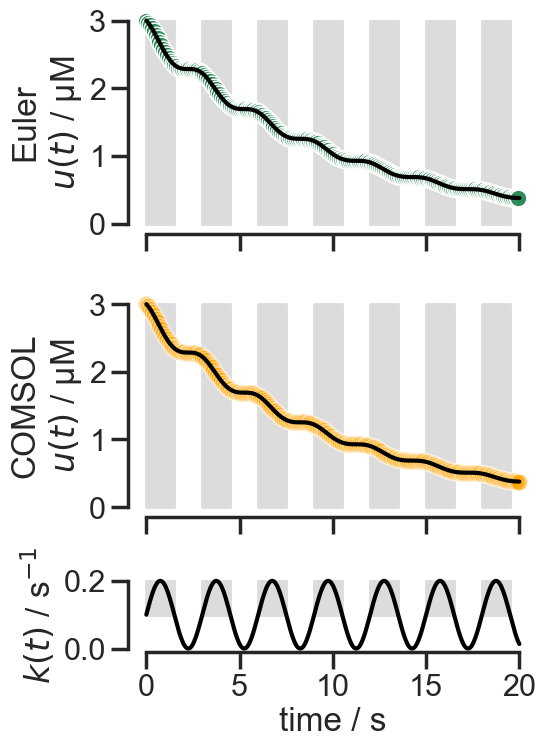

In [428]:
teststep=0.05
teststart=0
testend = 20
testk = 1/5 #s^-1
testperiod = 3
testtimes = np.linspace(teststart, testend, int((testend-teststart)/teststep))
testc0=0.003*1000

analytictest = testc0*np.exp(-(testk/2)*testtimes - (testk*testperiod/(4*np.pi)) + (testk*testperiod/(4*np.pi))*np.cos(2*np.pi*testtimes/ testperiod))

testdiscrete = np.zeros_like(testtimes)
testdiscrete[0]=testc0
for t, time in enumerate(testtimes[:-1]):
    testdiscrete[t+1] = testdiscrete[t]*(1 - (testk*teststep)/2 * (1+np.sin(2*np.pi*time / testperiod)))
    
    
fig, ax = plt.subplots(3, figsize=(6, 8), gridspec_kw={'height_ratios':[3,3,1]}, sharex=True)

ax[0].plot(testtimes, analytictest, label='analytic', color='k', zorder=3)
ax[1].plot(testtimes, analytictest, label='analytic', color='k', zorder=3)

ax[0].scatter(testtimes[::2], testdiscrete[::2],  label='discrete', color='seagreen', marker='o', ec='w', lw=1, alpha= 1)

ax[1].scatter(testdf1['% Time (s)'][::100], testdf1['Dependent variable u'][::100]*1000, marker='o',ec='w', lw=1, alpha=0.5, color='orange', label='comsol: rel tol 0.001')

ax[2].plot(testtimes, testk*(1+np.sin(2*np.pi*testtimes / testperiod))/2, color='k')

#plt.legend(fontsize=10)
[ax[0].fill_betweenx([0, testc0], i, i+testperiod/2, color='gainsboro', zorder=0) for i in np.arange(teststart, testend, testperiod)]
[ax[1].fill_betweenx([0, testc0], i, i+testperiod/2, color='gainsboro', zorder=0) for i in np.arange(teststart, testend, testperiod)]
[ax[2].fill_betweenx([testk/2, testk], i, i+testperiod/2, color='gainsboro', zorder=0) for i in np.arange(teststart, testend, testperiod)]
#[ax[2].fill_betweenx(testc0*(1+np.sin(2*np.pi*testtimes / testperiod))/2, 0, 3, color='gainsboro', zorder=0) for i in np.arange(teststart, testend, testperiod)]

ax[0].set_yticks([0, 1, 2, 3])
ax[1].set_yticks([0, 1, 2, 3])

ax[0].set_ylabel(f'Euler\n$u(t)$ / µM')
ax[1].set_ylabel(f'COMSOL\n$u(t)$ / µM')
ax[2].set_ylabel(f'$k(t)$ / s$^{{-1}}$')
ax[2].set_xlabel('time / s')

sns.despine(trim=True)
plt.tight_layout()
plt.savefig('/Users/anaduarte/Desktop/pulsedSineNumSolve.pdf', transparent=True)

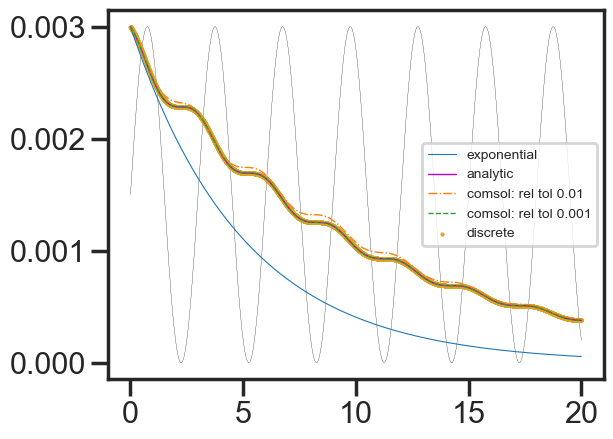

In [373]:
teststep=0.005
teststart=0
testend = 20
testk = 1/5 #s^-1
testperiod = 3
testtimes = np.linspace(teststart, testend, int((testend-teststart)/teststep))
testc0=0.003

analytictest = testc0*np.exp(-(testk/2)*testtimes - (testk*testperiod/(4*np.pi)) + (testk*testperiod/(4*np.pi))*np.cos(2*np.pi*testtimes/ testperiod))

testdiscrete = np.zeros_like(testtimes)
testdiscrete[0]=testc0
for t, time in enumerate(testtimes[:-1]):
    testdiscrete[t+1] = testdiscrete[t]*(1 - (testk*teststep)/2 * (1+np.sin(2*np.pi*time / testperiod)))

plt.plot(testtimes, testc0*(1+np.sin(2*np.pi*testtimes / testperiod))/2, lw=0.2, color='k', zorder=0)
plt.plot(testtimes, testc0*np.exp(-testk*testtimes), lw=0.8, label='exponential')
plt.plot(testtimes, analytictest, lw=1, label='analytic', color='m', zorder=2)
plt.scatter(testtimes, testdiscrete, s=1,  label='discrete', color='goldenrod', zorder=1)
plt.plot(testdf['% Time (s)'], testdf['Dependent variable u'], '-.', lw=1, label='comsol: rel tol 0.01')
plt.plot(testdf1['% Time (s)'], testdf1['Dependent variable u'], '--', lw=1, label='comsol: rel tol 0.001')
#plt.plot(testdf1['% Time (s)'], testdf1['Dependent variable u'], 'o-', lw=0.5, ms=0.3, label='comsol')
plt.legend(fontsize=10)

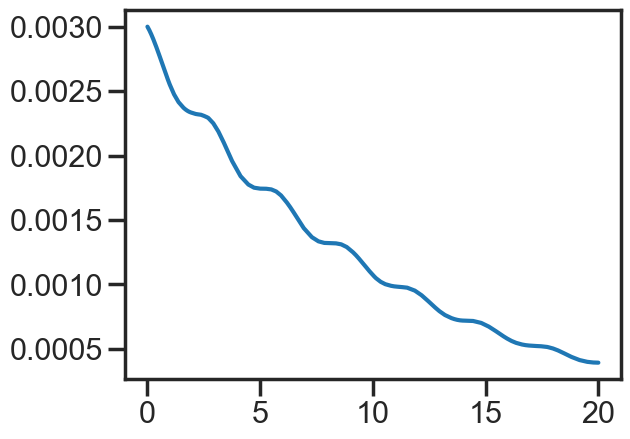

In [92]:
plt.plot(testdf['% Time (s)'], testdf['Dependent variable u'])

In [135]:
fname3='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250505_TEST_D40_tint1_signsin_0.001step.csv'
testdf3 = pd.read_csv(fname3, header=7)

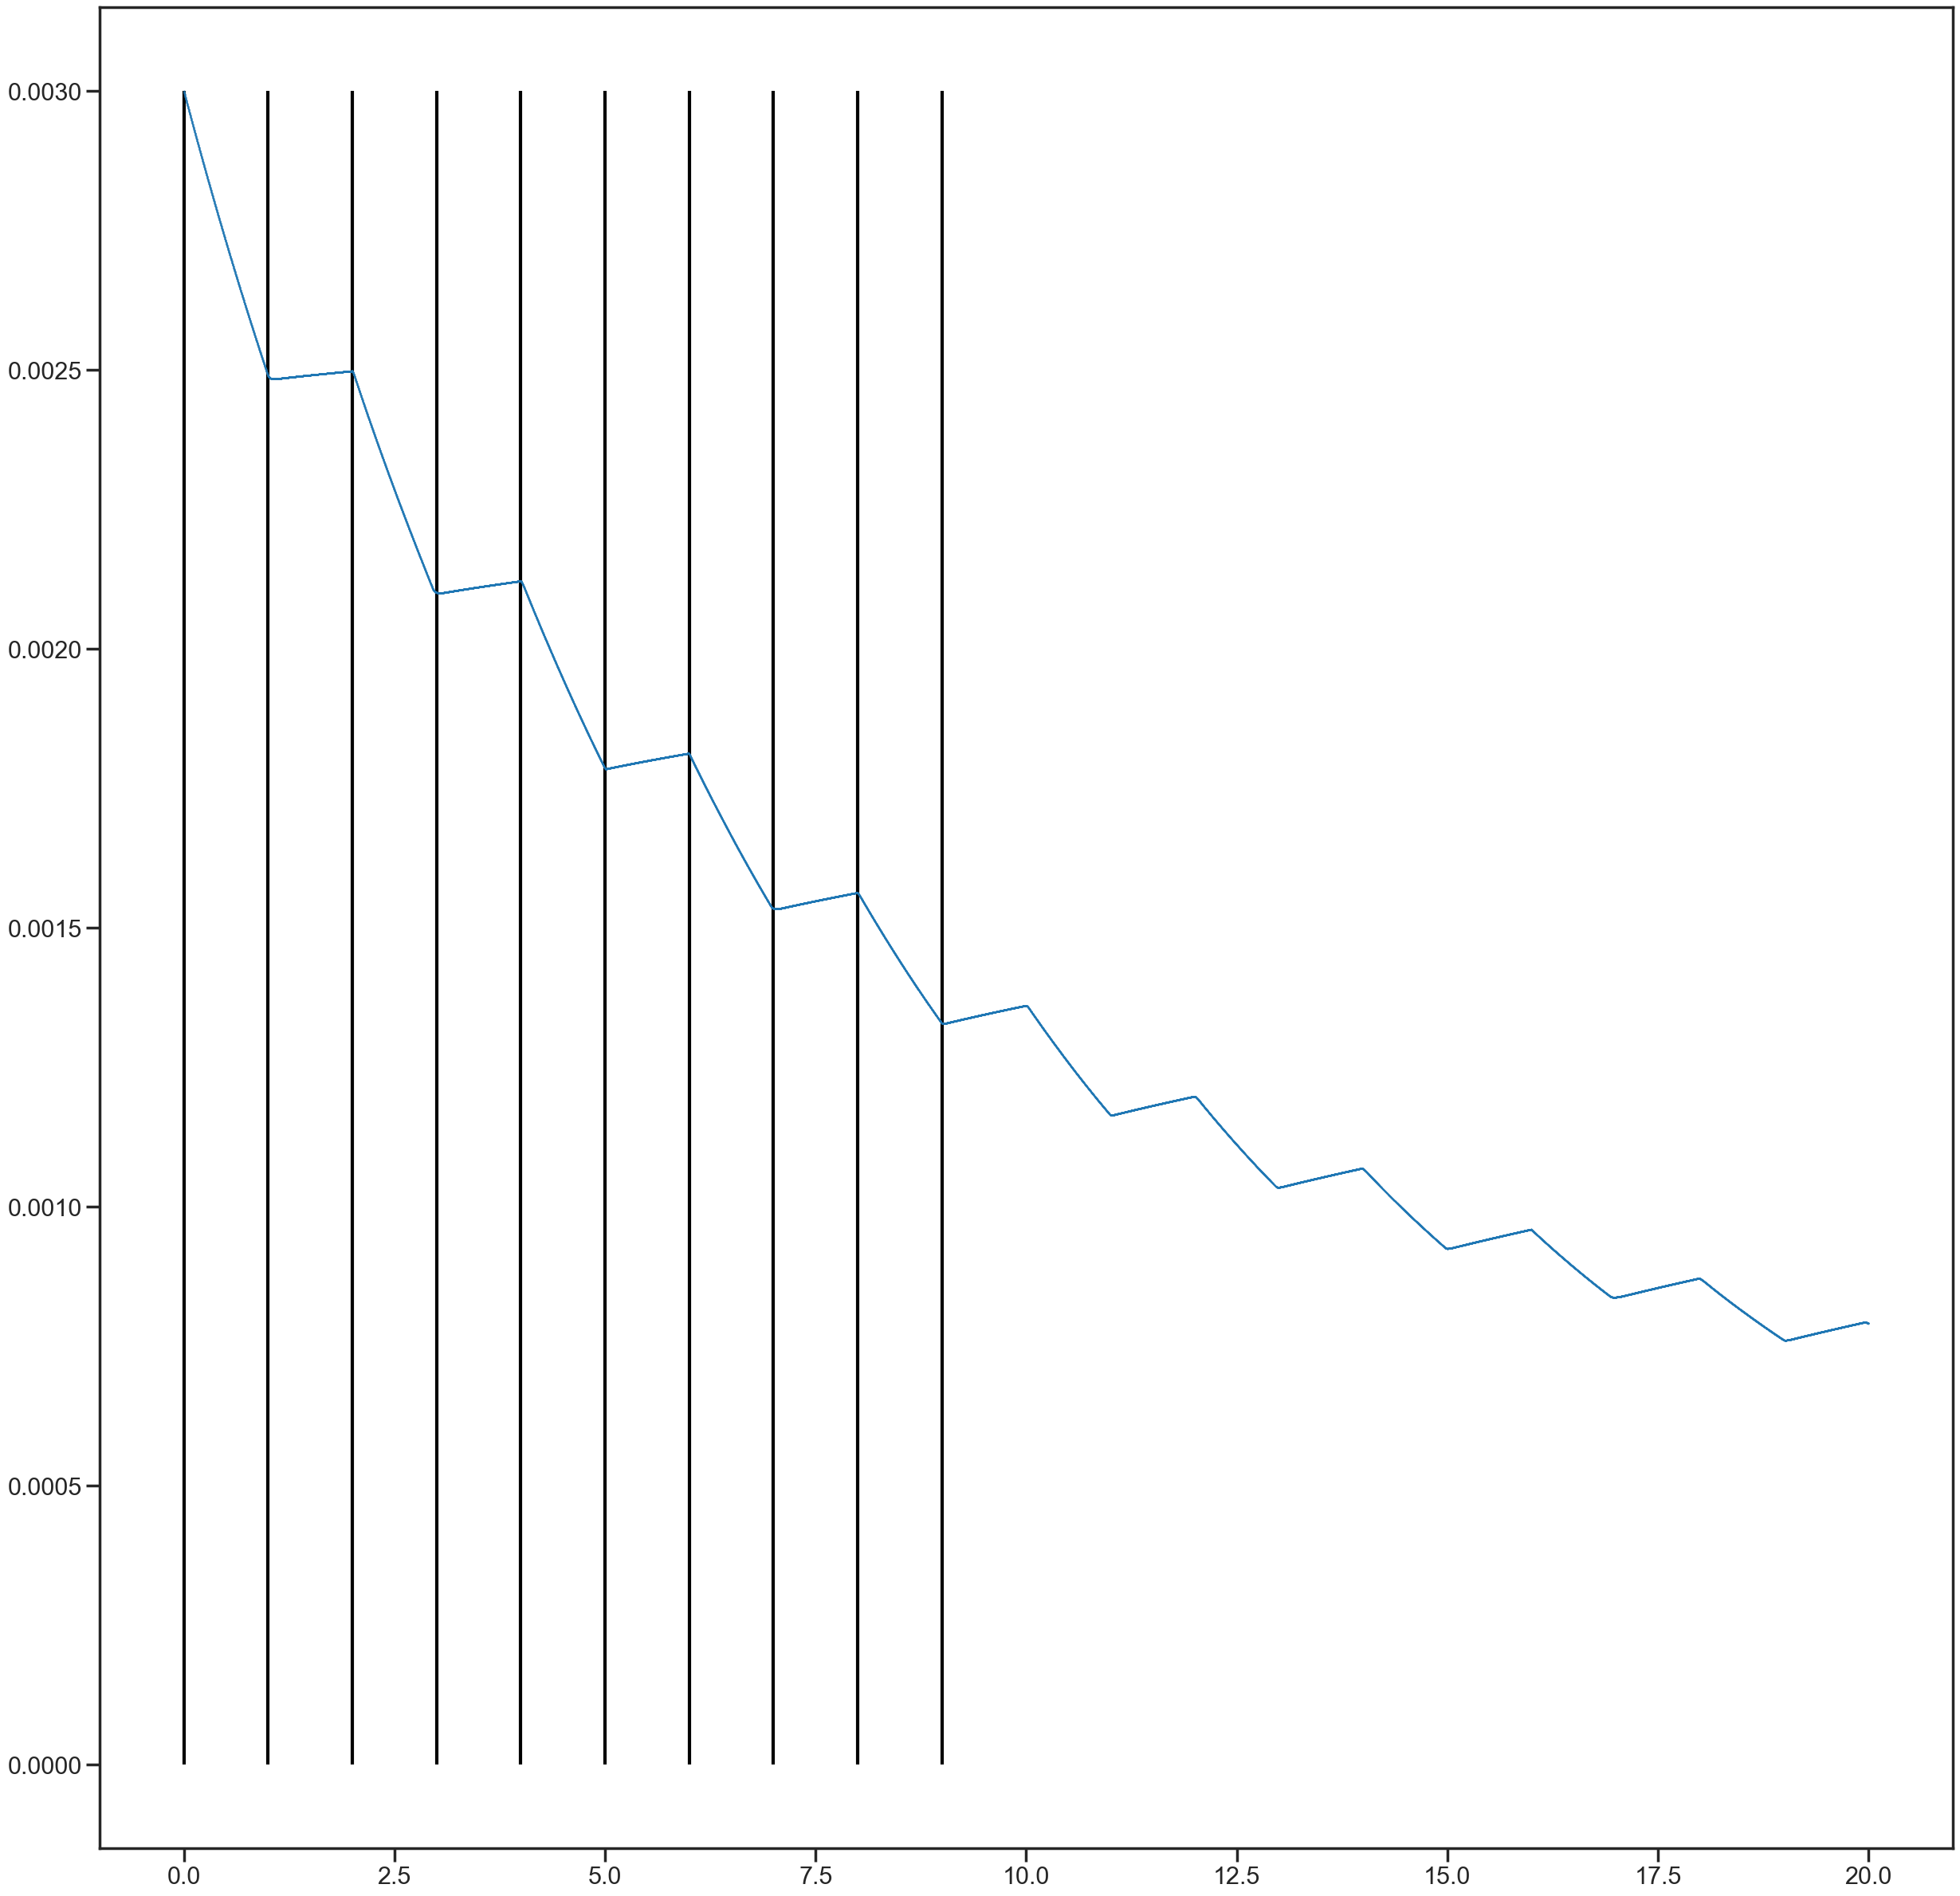

In [146]:
fig, ax = plt.subplots(figsize=(30,30))
plt.plot(testdf3['% Time (s)'], testdf3['Dependent variable u'], 'o-', lw=0.5, ms=0.3, label='comsol')
plt.vlines([ii for ii in range(10)], ymin=0, ymax=0.003, color='k')

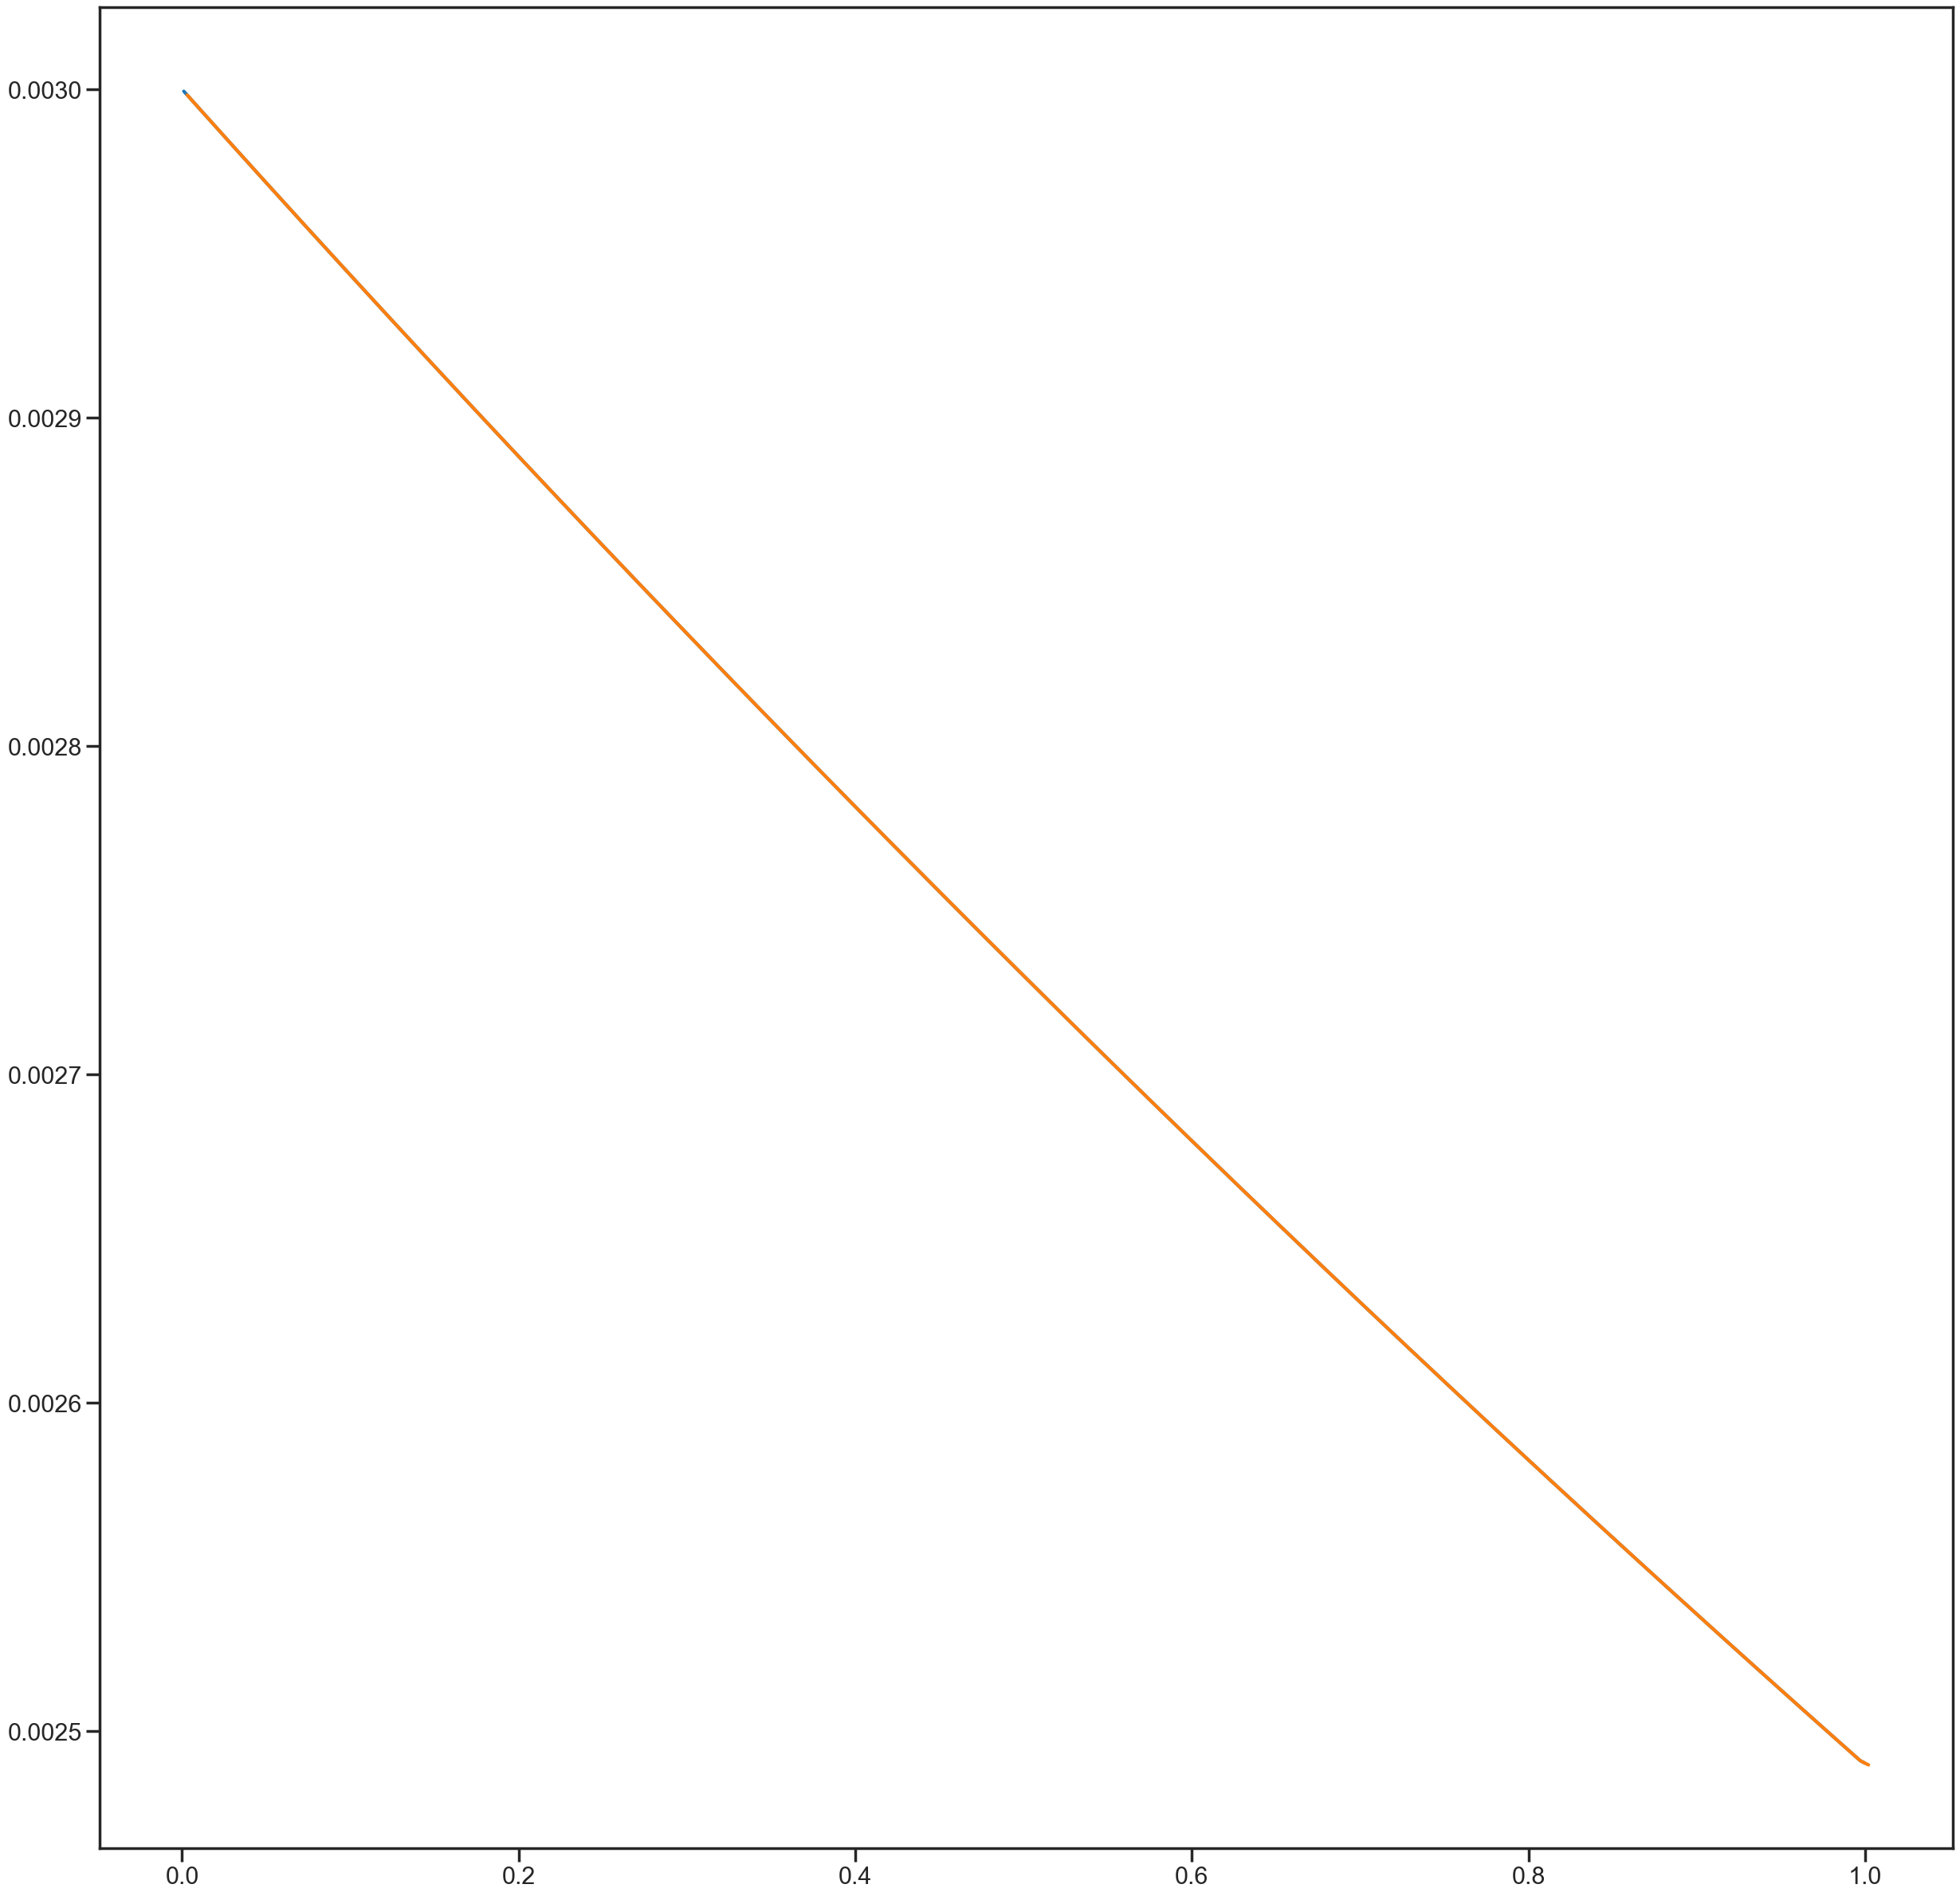

In [148]:
fig, ax = plt.subplots(figsize=(30,30))
for iistart in range(1,50,2):
    ax.plot(testdf3['% Time (s)'][iistart:iistart+int(1/0.001)],  testdf3['Dependent variable u'][iistart:iistart+int(1/0.001)])

# Pulsing with Events COMSOL

In [42]:
fnameD0='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250512_pulsedEvents_texcite150ms_tint20s_D0.csv'
fnameD40='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250512_pulsedEvents_texcite150ms_tint20s_D40um2s-1.csv'
fnameD40k30='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250512_pulsedEvents_texcite150ms_tint20s_D40um2s-1._k0.033s-1.csv'
fnameD40k10='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250512_pulsedEvents_texcite150ms_tint20s_D40um2s-1_k10s-1.csv'
dfD0 = pd.read_csv(fnameD0, header=7)
dfD40 = pd.read_csv(fnameD40, header=7)
dfD40k30 = pd.read_csv(fnameD40k30, header=7)
dfD40k10 = pd.read_csv(fnameD40k10, header=7)


In [41]:
dfD40['% Time (s)']

0           0.00
1           0.05
2           0.10
3           0.15
4           0.20
          ...   
79996    3999.80
79997    3999.85
79998    3999.90
79999    3999.95
80000    4000.00
Name: % Time (s), Length: 80001, dtype: float64

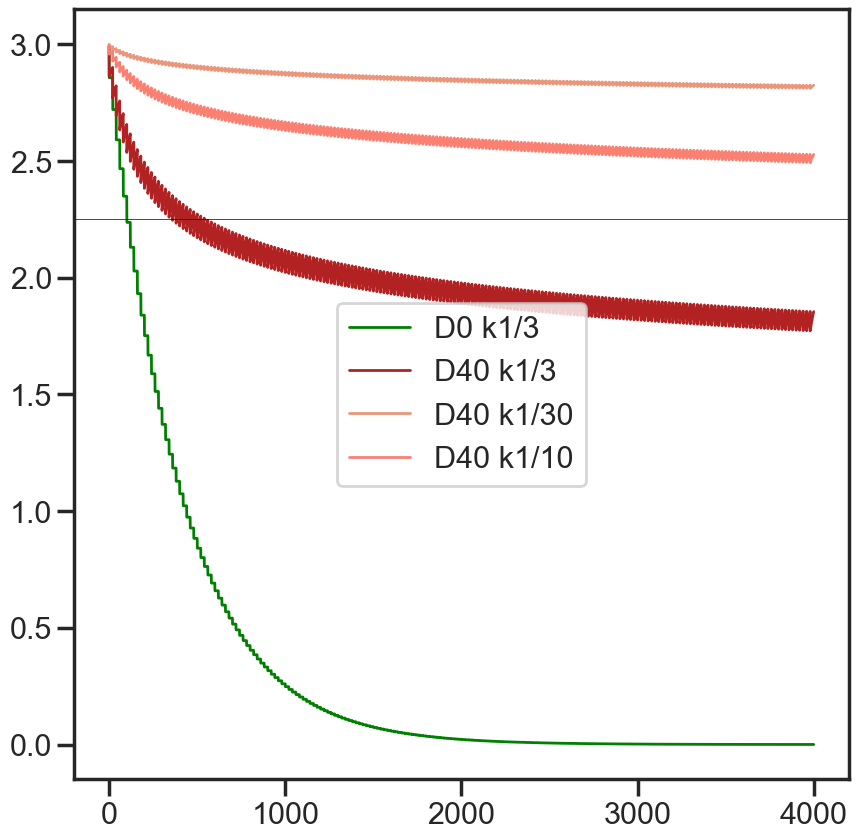

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(dfD0['% Time (s)'], dfD0['Dependent variable u']*1000, lw=2, color='green', label='D0 k1/3')
plt.plot(dfD40['% Time (s)'], dfD40['Dependent variable u']*1000, lw=2, color='firebrick', label='D40 k1/3')
plt.plot(dfD40k30['% Time (s)'], dfD40k30['Dependent variable u']*1000, lw=2, color='darksalmon', label='D40 k1/30')
plt.plot(dfD40k10['% Time (s)'], dfD40k10['Dependent variable u']*1000, lw=2, color='salmon', label='D40 k1/10')
#plt.plot(dfD40['% Time (s)'][::400], dfD40['Dependent variable u'][::400]*1000, lw=2, color='green', label='D40')
#plt.plot(dfD40['% Time (s)'][3::400], dfD40['Dependent variable u'][3::400]*1000, lw=2, color='blue', label='D40')
plt.legend()
plt.axhline(3*0.75, color='k', lw=0.5)
plt.savefig('/Users/anaduarte/Desktop/comsol--works--photobleaching.pdf', transparent=True)

In [60]:
3*0.75

2.25

In [61]:
fnameD0='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250512_pulsedEvents_texcite150ms_tint20s_D0.csv'
dfD0 = pd.read_csv(fnameD0, header=7)
fnameD40='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250512_pulsedEvents_texcite150ms_tint20s_D40um2s-1.csv'
dfD40 = pd.read_csv(fnameD40, header=7)
fnameD40k30='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250512_pulsedEvents_texcite150ms_tint20s_D40um2s-1._k0.033s-1.csv'
dfD40k30 = pd.read_csv(fnameD40k30, header=7)
fnameD40k10='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250512_pulsedEvents_texcite150ms_tint20s_D40um2s-1_k10s-1.csv'
dfD40k10 = pd.read_csv(fnameD40k10, header=7)


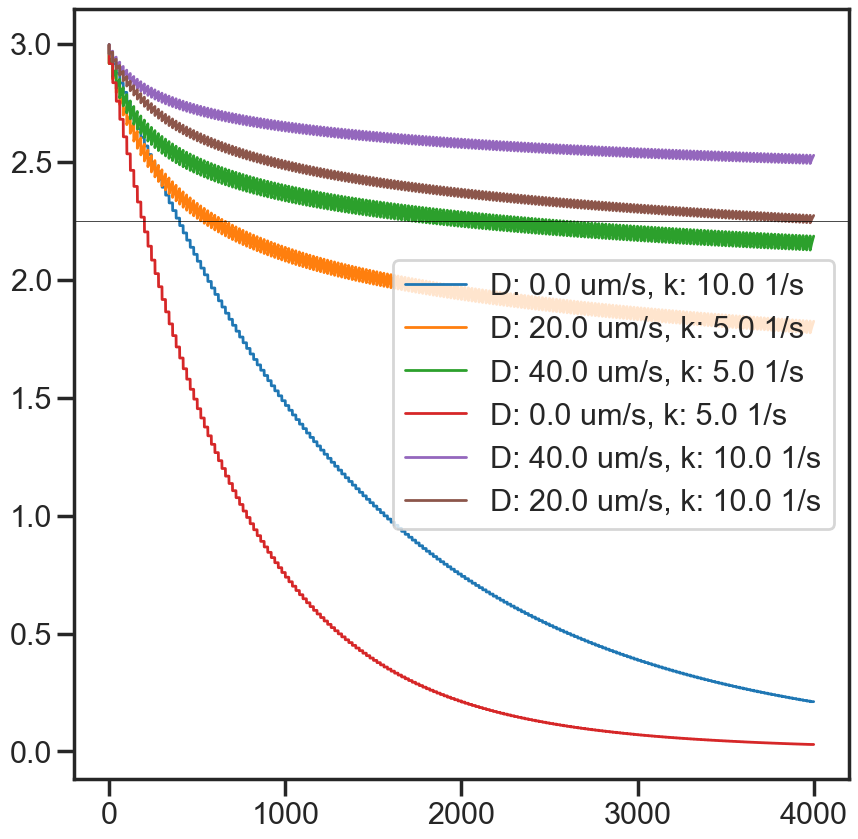

In [180]:
fig, ax = plt.subplots(figsize=(10, 10))

for i in np.unique(timeTracedf['expIDarbitrary']):
    tempdf = timeTracedf[timeTracedf['expIDarbitrary']==i]
    plt.plot(tempdf['% Time (s)'], tempdf['Dependent variable u']*1000, lw=2, label='D: '+str(tempdf['D'][0])+' um/s, k: '+str(tempdf['kb'][0])+' 1/s')
plt.legend()
plt.axhline(3*0.75, color='k', lw=0.5)

# Make a DataFrame for the time trace csv's

In [211]:
timeTraceNames = glob.glob('/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/*timeTrace*.csv')
timeTraceStaginglist = []
for i, f in enumerate(timeTraceNames):
    tempdf = pd.read_csv(f, header=7)
    tempdf['D'] = np.ones(len(tempdf))*int(f.split('_')[-3].split('D')[1]) #diffusion constant in um^2/s
    tempdf['kb'] = np.ones(len(tempdf))*int(f.split('_')[-2].split('k')[1]) #bleach rate in 1/s
    tempdf['tint'] = np.ones(len(tempdf))*float(f.split('tint')[1].split('s_')[0]) #interval time in s
    tempdf['texcite'] = np.ones(len(tempdf))*float(f.split('texcite')[1].split('ms_')[0])/1000 #excitation time in s
    tempdf['file'] = [f]*len(tempdf)
    tempdf['expIDarbitrary'] = i*np.ones(len(tempdf)).astype(int)
    timeTraceStaginglist.append(tempdf)
timeTracedf = pd.concat(timeTraceStaginglist)



# Make a DataFrame for the spatial trace cut Line csv's

In [212]:
t_start = 0 #initial time
t_end = 4000 # final time
spacing = 0.05 # seconds between each measurement
interval = 800 #plotting interval

numb_times = int((t_end-t_start)/spacing)//interval + 1 #number of times in the plot

comsol_times = np.linspace(t_start, t_end, numb_times) #given in s

cutLineNames = glob.glob('/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/*cutLine*.csv')
cutLineStaginglist = []
for i, f in enumerate(cutLineNames):
    tempdf = pd.read_csv(f, header=7)
    numb_pos = len(tempdf)//numb_times #number of positions in each line
    tempdf['time'] = np.repeat(comsol_times, numb_pos)
    tempdf['D'] = np.ones(len(tempdf))*int(f.split('_')[-3].split('D')[1]) #diffusion constant in um^2/s
    tempdf['kb'] = np.ones(len(tempdf))*int(f.split('_')[-2].split('k')[1]) #bleach rate in 1/s
    tempdf['tint'] = np.ones(len(tempdf))*float(f.split('tint')[1].split('s_')[0]) #interval time in s
    tempdf['texcite'] = np.ones(len(tempdf))*float(f.split('texcite')[1].split('ms_')[0])/1000 #excitation time in s
    tempdf['file'] = [f]*len(tempdf)
    tempdf['expIDarbitrary'] = i*np.ones(len(tempdf)).astype(int)
    cutLineStaginglist.append(tempdf)
cutLinedf = pd.concat(cutLineStaginglist)

# time plots

## Single Exponential +Constant fit

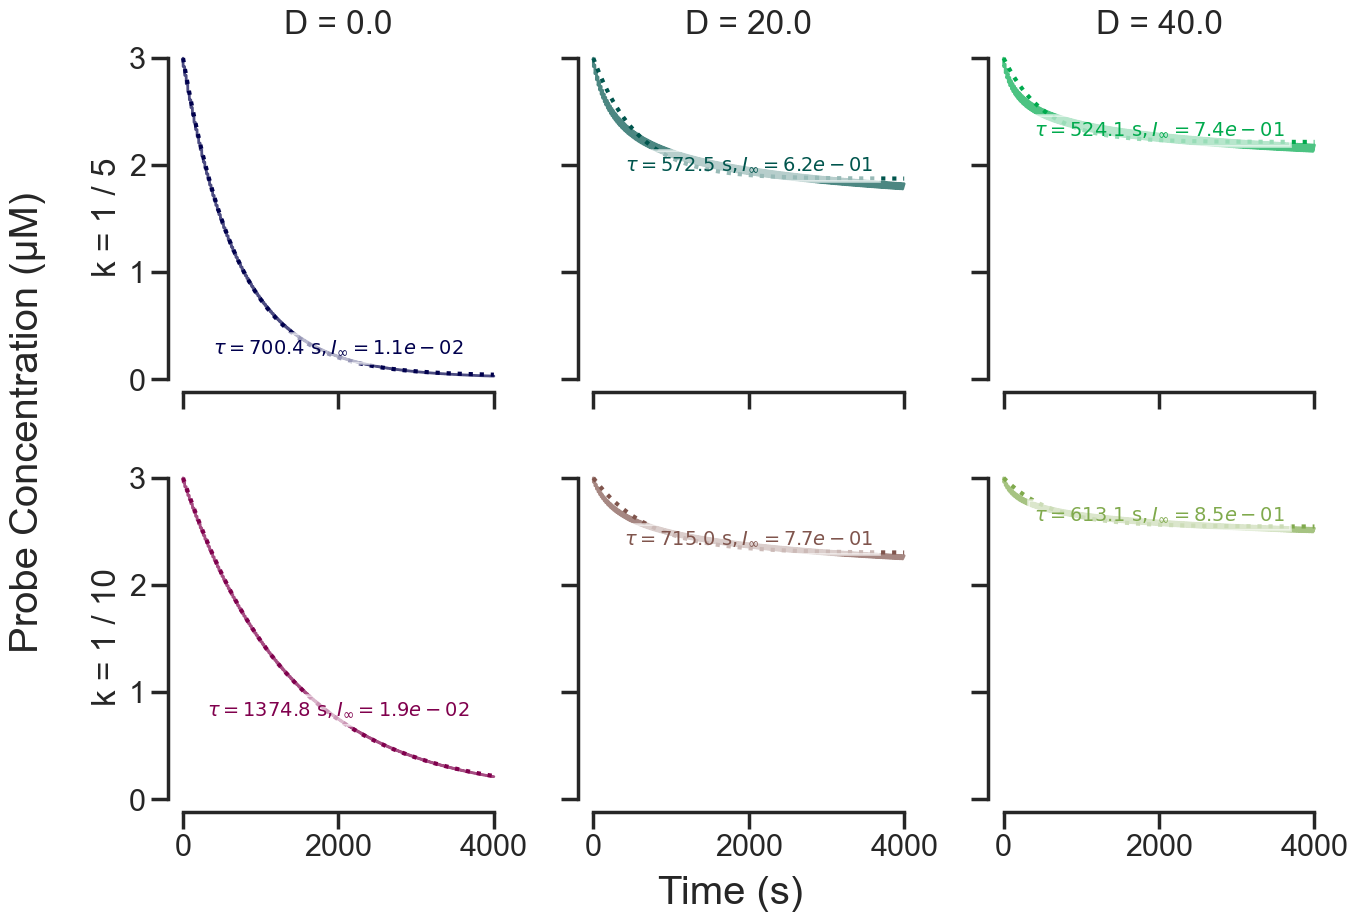

In [234]:
fig, ax = plt.subplots(len(np.unique(timeTracedf['kb'])), len(np.unique(timeTracedf['D'])), figsize = (15, 10), sharex=True, sharey=True)
for i, ki in enumerate(np.unique(timeTracedf['kb'])):
    ax[i][0].set_ylabel(f'k = 1 / {int(ki)}')
    for j, Dj in enumerate(np.unique(timeTracedf['D'])):
        ax[0][j].set_title(f'D = {Dj}')
        tempdf = timeTracedf[(timeTracedf['kb']==ki) & (timeTracedf['D']==Dj) & (timeTracedf['tint']==20)]
        ax[i][j].plot(tempdf['% Time (s)'], 
                      tempdf['Dependent variable u']*1000, lw=2, 
                      label='D: '+str(tempdf['D'][0])+' um/s, k: '+str(tempdf['kb'][0])+' 1/s',
                      color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3, 0.7), 
                      ls='-')

        temp_fit = singExpConstFit_max1(tempdf['% Time (s)'], 
                                    tempdf['Dependent variable u']/tempdf['Dependent variable u'].max(), 
                                    (1/ki, np.array(tempdf['Dependent variable u'])[-1]/tempdf['Dependent variable u'].max()))
        ax[i][j].plot(tempdf['% Time (s)'], 
                     singExpConst_max1(tempdf['% Time (s)'], temp_fit.x)*tempdf['Dependent variable u'].max()*10**3,
                     ':', color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3))
    
        # label fit results in plot
        fitString=r'$\tau ='+str(round(temp_fit.x[0], 1))+'~\mathrm{s}, I_\infty = '+'{:.1e}'.format(round(temp_fit.x[-1],5))+'$'
        ax[i][j].text(np.array(tempdf['% Time (s)'])[-1]/2, 
                      singExpConst_max1(np.array(tempdf['% Time (s)'])[-1]/2, temp_fit.x)*tempdf['Dependent variable u'].max()*10**3,
                      fitString,
                       ha='center',
                       va='bottom',
                       color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3, 1),
                       fontsize=14,
                       bbox=dict(facecolor='white', alpha=0.6))
fig.supylabel('Probe Concentration (µM)')
fig.supxlabel('Time (s)')

#stylish
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250516_timeTraceVarykandDSingExp.pdf", bbox_inches='tight', transparent=True)

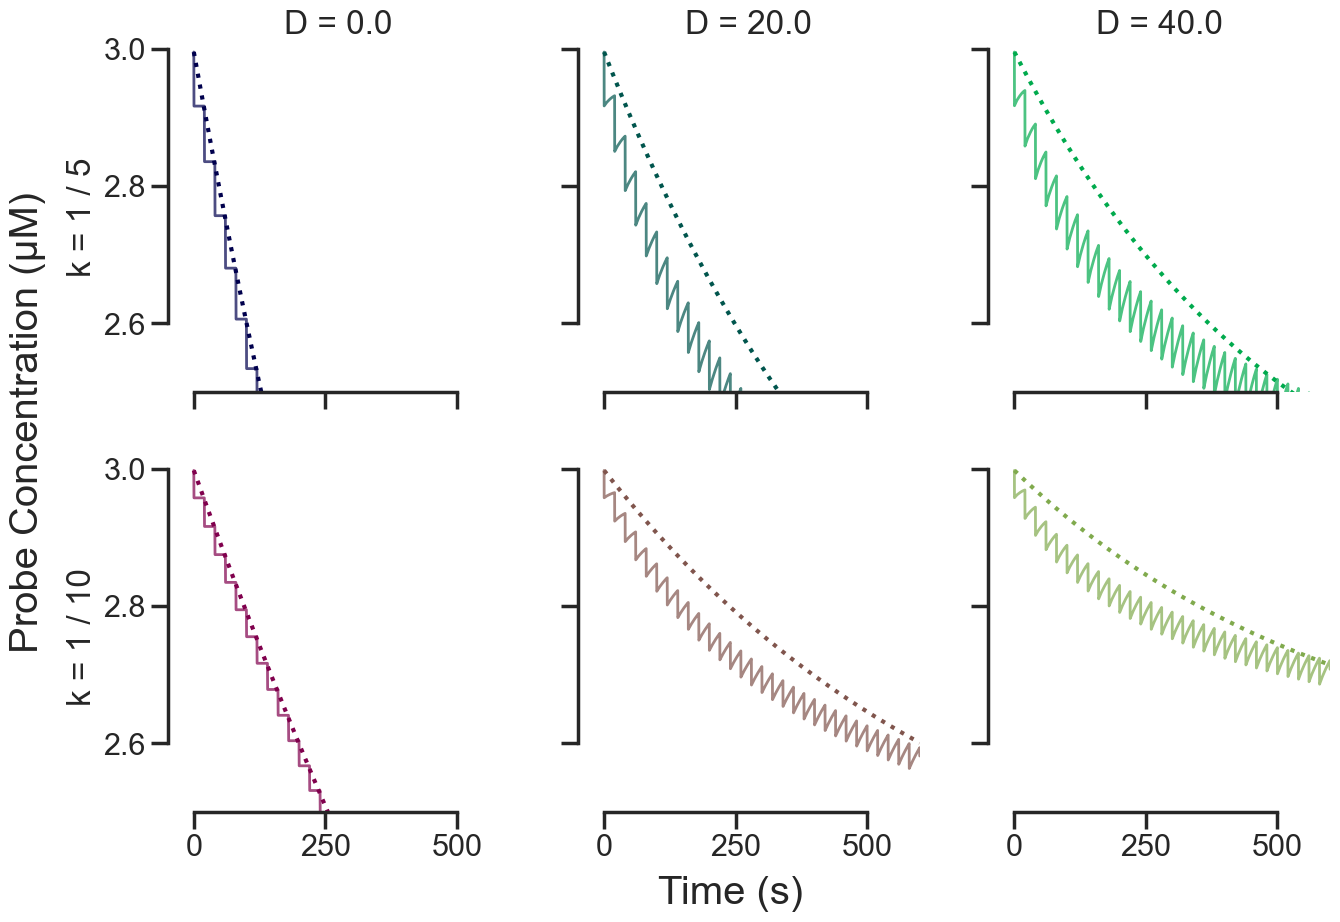

In [233]:
fig, ax = plt.subplots(len(np.unique(timeTracedf['kb'])), len(np.unique(timeTracedf['D'])), figsize = (15, 10), sharex=True, sharey=True)
for i, ki in enumerate(np.unique(timeTracedf['kb'])):
    ax[i][0].set_ylabel(f'k = 1 / {int(ki)}')
    for j, Dj in enumerate(np.unique(timeTracedf['D'])):
        ax[0][j].set_title(f'D = {Dj}')
        tempdf = timeTracedf[(timeTracedf['kb']==ki) & (timeTracedf['D']==Dj) & (timeTracedf['tint']==20)]
        ax[i][j].plot(tempdf['% Time (s)'], 
                      tempdf['Dependent variable u']*1000, lw=2, 
                      label='D: '+str(tempdf['D'][0])+' um/s, k: '+str(tempdf['kb'][0])+' 1/s',
                      color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3, 0.7), 
                      ls='-')

        temp_fit = singExpConstFit_max1(tempdf['% Time (s)'], 
                                    tempdf['Dependent variable u']/tempdf['Dependent variable u'].max(), 
                                    (1/ki, np.array(tempdf['Dependent variable u'])[-1]/tempdf['Dependent variable u'].max()))
        ax[i][j].plot(tempdf['% Time (s)'], 
                     singExpConst_max1(tempdf['% Time (s)'], temp_fit.x)*tempdf['Dependent variable u'].max()*10**3,
                     ':', color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3))
    
        # label fit results in plot
        # fitString=r'$\tau ='+str(round(temp_fit.x[0], 1))+'~\mathrm{s}, I_\infty = '+'{:.1e}'.format(round(temp_fit.x[-1],5))+'$'
        # ax[i][j].text(np.array(tempdf['% Time (s)'])[-1]/2, 
        #               singExpConst_max1(np.array(tempdf['% Time (s)'])[-1]/2, temp_fit.x)*tempdf['Dependent variable u'].max()*10**3,
        #               fitString,
        #                ha='center',
        #                va='bottom',
        #                color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3, 1),
        #                fontsize=14,
        #                bbox=dict(facecolor='white', alpha=0.6))
ax[0][0].set_ylim(2.5, 3.01)
ax[0][0].set_xlim(-50, 600)
fig.supylabel('Probe Concentration (µM)')
fig.supxlabel('Time (s)')

#stylish
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250516_timeTraceVarykandDSingExpInsets.pdf", bbox_inches='tight', transparent=True)

## double exponential fit

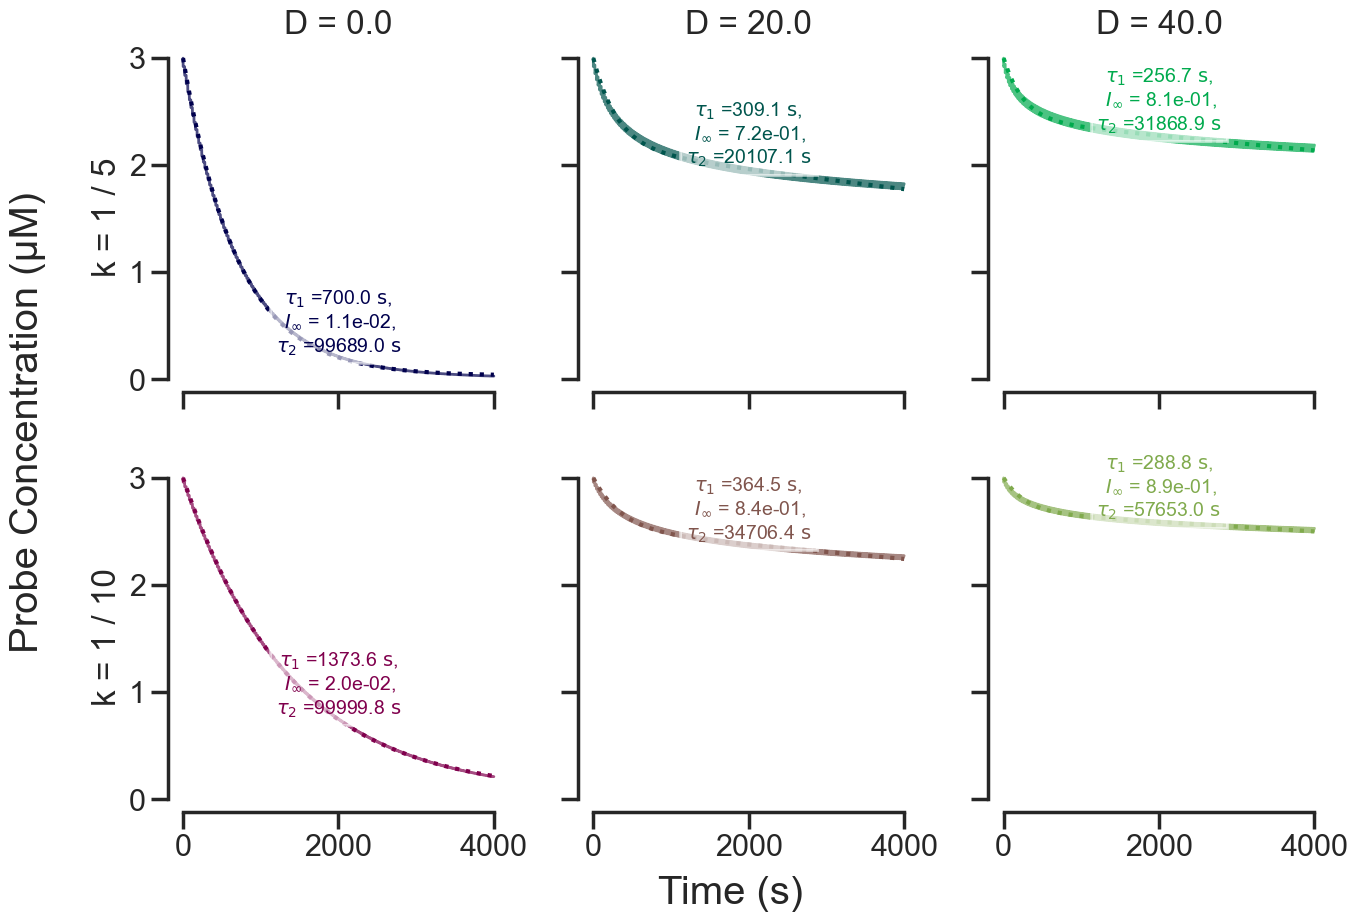

In [232]:
fig, ax = plt.subplots(len(np.unique(timeTracedf['kb'])), len(np.unique(timeTracedf['D'])), figsize = (15, 10), sharex=True, sharey=True)
for i, ki in enumerate(np.unique(timeTracedf['kb'])):
    ax[i][0].set_ylabel(f'k = 1 / {int(ki)}')
    for j, Dj in enumerate(np.unique(timeTracedf['D'])):
        ax[0][j].set_title(f'D = {Dj}')
        tempdf = timeTracedf[(timeTracedf['kb']==ki) & (timeTracedf['D']==Dj) & (timeTracedf['tint']==20)]
        ax[i][j].plot(tempdf['% Time (s)'], 
                      tempdf['Dependent variable u']*1000, lw=2, 
                      label='D: '+str(tempdf['D'][0])+' um/s, k: '+str(tempdf['kb'][0])+' 1/s',
                      color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3, 0.7), 
                      ls='-')

        temp_fit = doubExpFit_max1(tempdf['% Time (s)'], 
                                    tempdf['Dependent variable u']/tempdf['Dependent variable u'].max(), 
                                    (1/ki, np.array(tempdf['Dependent variable u'])[-1]/tempdf['Dependent variable u'].max(), 100000))
        ax[i][j].plot(tempdf['% Time (s)'], 
                     doubExp_max1(tempdf['% Time (s)'], temp_fit.x)*tempdf['Dependent variable u'].max()*10**3,
                     ':', color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3))
    
        # label fit results in plot
        fitString=r'$\tau_1$ ='+str(round(temp_fit.x[0], 1))+'$~\mathrm{s}$,\n $I_\infty$ = '+'{:.1e}'.format(round(temp_fit.x[1],5))+', \n'+r'$\tau_2$ ='+str(round(temp_fit.x[2], 1))+'$~\mathrm{s}$'
        ax[i][j].text(np.array(tempdf['% Time (s)'])[-1]/2, 
                      doubExp_max1(np.array(tempdf['% Time (s)'])[-1]/2, temp_fit.x)*tempdf['Dependent variable u'].max()*10**3,
                      fitString,
                       ha='center',
                       va='bottom',
                       color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3, 1),
                       fontsize=14,
                       bbox=dict(facecolor='white', alpha=0.6))
fig.supylabel('Probe Concentration (µM)')
fig.supxlabel('Time (s)')

#stylish
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250516_timeTraceVarykandDDoubExp.pdf", bbox_inches='tight', transparent=True)

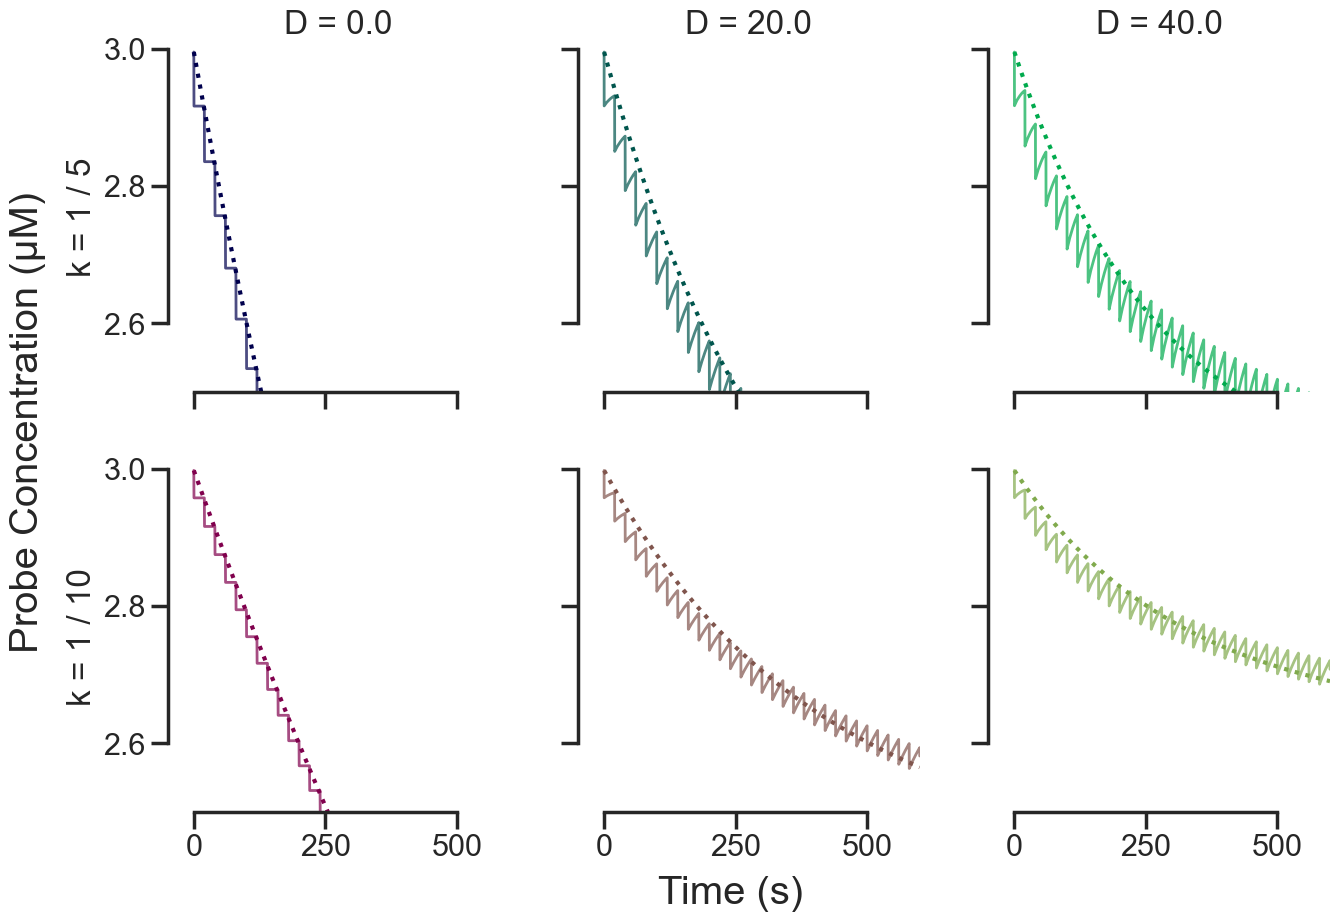

In [231]:
fig, ax = plt.subplots(len(np.unique(timeTracedf['kb'])), len(np.unique(timeTracedf['D'])), figsize = (15, 10), sharex=True, sharey=True)
for i, ki in enumerate(np.unique(timeTracedf['kb'])):
    ax[i][0].set_ylabel(f'k = 1 / {int(ki)}')
    for j, Dj in enumerate(np.unique(timeTracedf['D'])):
        ax[0][j].set_title(f'D = {Dj}')
        tempdf = timeTracedf[(timeTracedf['kb']==ki) & (timeTracedf['D']==Dj) & (timeTracedf['tint']==20)]
        ax[i][j].plot(tempdf['% Time (s)'], 
                      tempdf['Dependent variable u']*1000, lw=2, 
                      label='D: '+str(tempdf['D'][0])+' um/s, k: '+str(tempdf['kb'][0])+' 1/s',
                      color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3, 0.7), 
                      ls='-')

        temp_fit = doubExpFit_max1(tempdf['% Time (s)'], 
                                    tempdf['Dependent variable u']/tempdf['Dependent variable u'].max(), 
                                    (1/ki, np.array(tempdf['Dependent variable u'])[-1]/tempdf['Dependent variable u'].max(), 100000))
        ax[i][j].plot(tempdf['% Time (s)'], 
                     doubExp_max1(tempdf['% Time (s)'], temp_fit.x)*tempdf['Dependent variable u'].max()*10**3,
                     ':', color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3))
    
        # # label fit results in plot
        # fitString=r'$\tau_1$ ='+str(round(temp_fit.x[0], 1))+'$~\mathrm{s}$,\n $I_\infty$ = '+'{:.1e}'.format(round(temp_fit.x[1],5))+', \n'+r'$\tau_2$ ='+str(round(temp_fit.x[2], 1))+'$~\mathrm{s}$'
        # ax[i][j].text(np.array(tempdf['% Time (s)'])[-1]/2, 
        #               doubExp_max1(np.array(tempdf['% Time (s)'])[-1]/2, temp_fit.x)*tempdf['Dependent variable u'].max()*10**3,
        #               fitString,
        #                ha='center',
        #                va='bottom',
        #                color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3, 1),
        #                fontsize=14,
        #                bbox=dict(facecolor='white', alpha=0.6))
        
ax[0][0].set_ylim(2.5, 3.01)
ax[0][0].set_xlim(-50, 600)
fig.supylabel('Probe Concentration (µM)')
fig.supxlabel('Time (s)')

#stylish
sns.despine(trim=True)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250516_timeTraceVarykandDDoubExpInsets.pdf", bbox_inches='tight', transparent=True)

# space plots

In [135]:
cutLinedf[(cutLinedf['kb']==ki) & (cutLinedf['D']==Dj) & (cutLinedf['time']==time)]

% Arc length (m)  Dependent variable u  time    D   kb  tint  texcite  \
491          0.000000                 0.003  40.0  0.0  5.0  20.0     0.15   
492          0.000020                 0.003  40.0  0.0  5.0  20.0     0.15   
493          0.000032                 0.003  40.0  0.0  5.0  20.0     0.15   
494          0.000052                 0.003  40.0  0.0  5.0  20.0     0.15   
495          0.000054                 0.003  40.0  0.0  5.0  20.0     0.15   
..                ...                   ...   ...  ...  ...   ...      ...   
977          0.002927                 0.003  40.0  0.0  5.0  20.0     0.15   
978          0.002961                 0.003  40.0  0.0  5.0  20.0     0.15   
979          0.002974                 0.003  40.0  0.0  5.0  20.0     0.15   
980          0.002997                 0.003  40.0  0.0  5.0  20.0     0.15   
981          0.003000                 0.003  40.0  0.0  5.0  20.0     0.15   

                                                  file  expIDarbitrary  
491  /Users/anaduarte/RPgroup/am_atp/data/COMSOL/ph...               2  
492  /Users/anaduarte/RPgroup/am_atp/data/COMSOL/ph...               2  
493  /Users/anaduarte/RPgroup/am_atp/data/COMSOL/ph...               2  
494  /Users/anaduarte/RPgroup/am_atp/data/COMSOL/ph...               2  
495  /Users/anaduarte/RPgroup/am_atp/data/COMSOL/ph...               2  
..                                                 ...             ...  
977  /Users/anaduarte/RPgroup/am_atp/data/COMSOL/ph...               2  
978  /Users/anaduarte/RPgroup/am_atp/data/COMSOL/ph...               2  
979  /Users/anaduarte/RPgroup/am_atp/data/COMSOL/ph...               2  
980  /Users/anaduarte/RPgroup/am_atp/data/COMSOL/ph...               2  
981  /Users/anaduarte/RPgroup/am_atp/data/COMSOL/ph...               2  

[491 rows x 9 columns]

In [144]:
np.unique(cutLinedf['time'])/np.max(tempdf['time'])

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

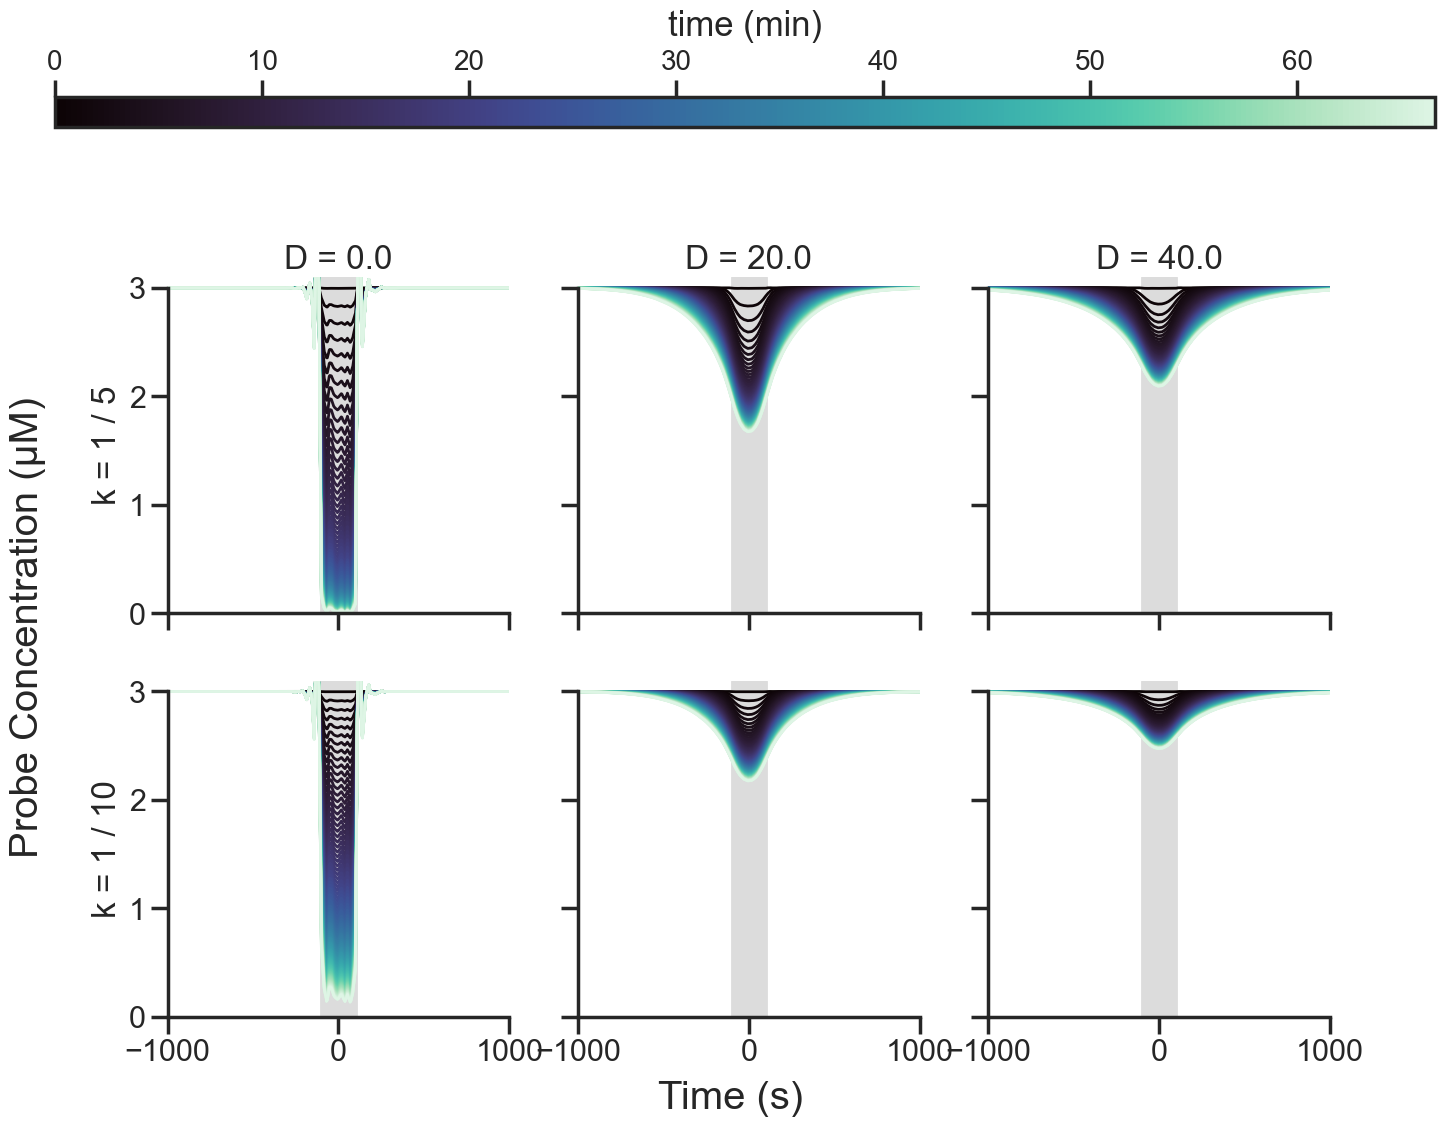

In [244]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(np.unique(cutLinedf['time'])))]

fig, ax = plt.subplots(len(np.unique(cutLinedf['kb'])), len(np.unique(cutLinedf['D'])), figsize = (15, 10), sharex=True, sharey=True)
for i, ki in enumerate(np.unique(cutLinedf['kb'])):
    ax[i][0].set_ylabel(f'k = 1 / {int(ki)}')
    for j, Dj in enumerate(np.unique(cutLinedf['D'])):
        ax[0][j].set_title(f'D = {Dj}')
        for t, time in enumerate(np.unique(cutLinedf['time'])):
            tempdf = cutLinedf[(cutLinedf['kb']==ki) & (cutLinedf['D']==Dj) & (cutLinedf['time']==time) & (cutLinedf['tint']==20)]
            ax[i][j].plot((tempdf['% Arc length (m)']-(np.max(tempdf['% Arc length (m)'])/2))*1e6, 
                          tempdf['Dependent variable u']*1000, lw=2, 
                          #label='D: '+str(tempdf['D'][0])+' um/s, k: '+str(tempdf['kb'][0])+' 1/s',
                          color=colorList[t], 
                          ls='-')
        ax[i][j].fill_betweenx([0, 3.1], -100, 100, color='gainsboro', zorder=0)
        #ax[i][j].fill_betweenx([0, 3.1], -50, 50, color='ghostwhite', zorder=0)

ax[0][0].set_ylim(0,3.1)
ax[0][0].set_xlim(-1000,1000)
fig.supylabel('Probe Concentration (µM)')
fig.supxlabel('Time (s)')
#stylish
sns.despine(trim=True)

######
# Adjust the top margin to make space for the colorbar
fig.subplots_adjust(top=0.85)

# Create an axis for the colorbar that spans all columns
cax = fig.add_axes([0.05, 1, 0.92, 0.03])  # [left, bottom, width, height]

# Create the colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("mako", as_cmap=True), norm=mcolors.Normalize(vmin=min(cutLinedf['time'])/60, 
                                                                 vmax=max(cutLinedf['time'])/60)),
                    cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20)

# Move colorbar label and ticks to the top
cbar.ax.xaxis.set_ticks_position('top')   # Move ticks to top
cbar.ax.xaxis.set_label_position('top')   # Move label to top
cbar.set_label('time (min)', fontsize=25, labelpad=10)


srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250516_cutLineTraceVarykandD.pdf", bbox_inches='tight', transparent=True)

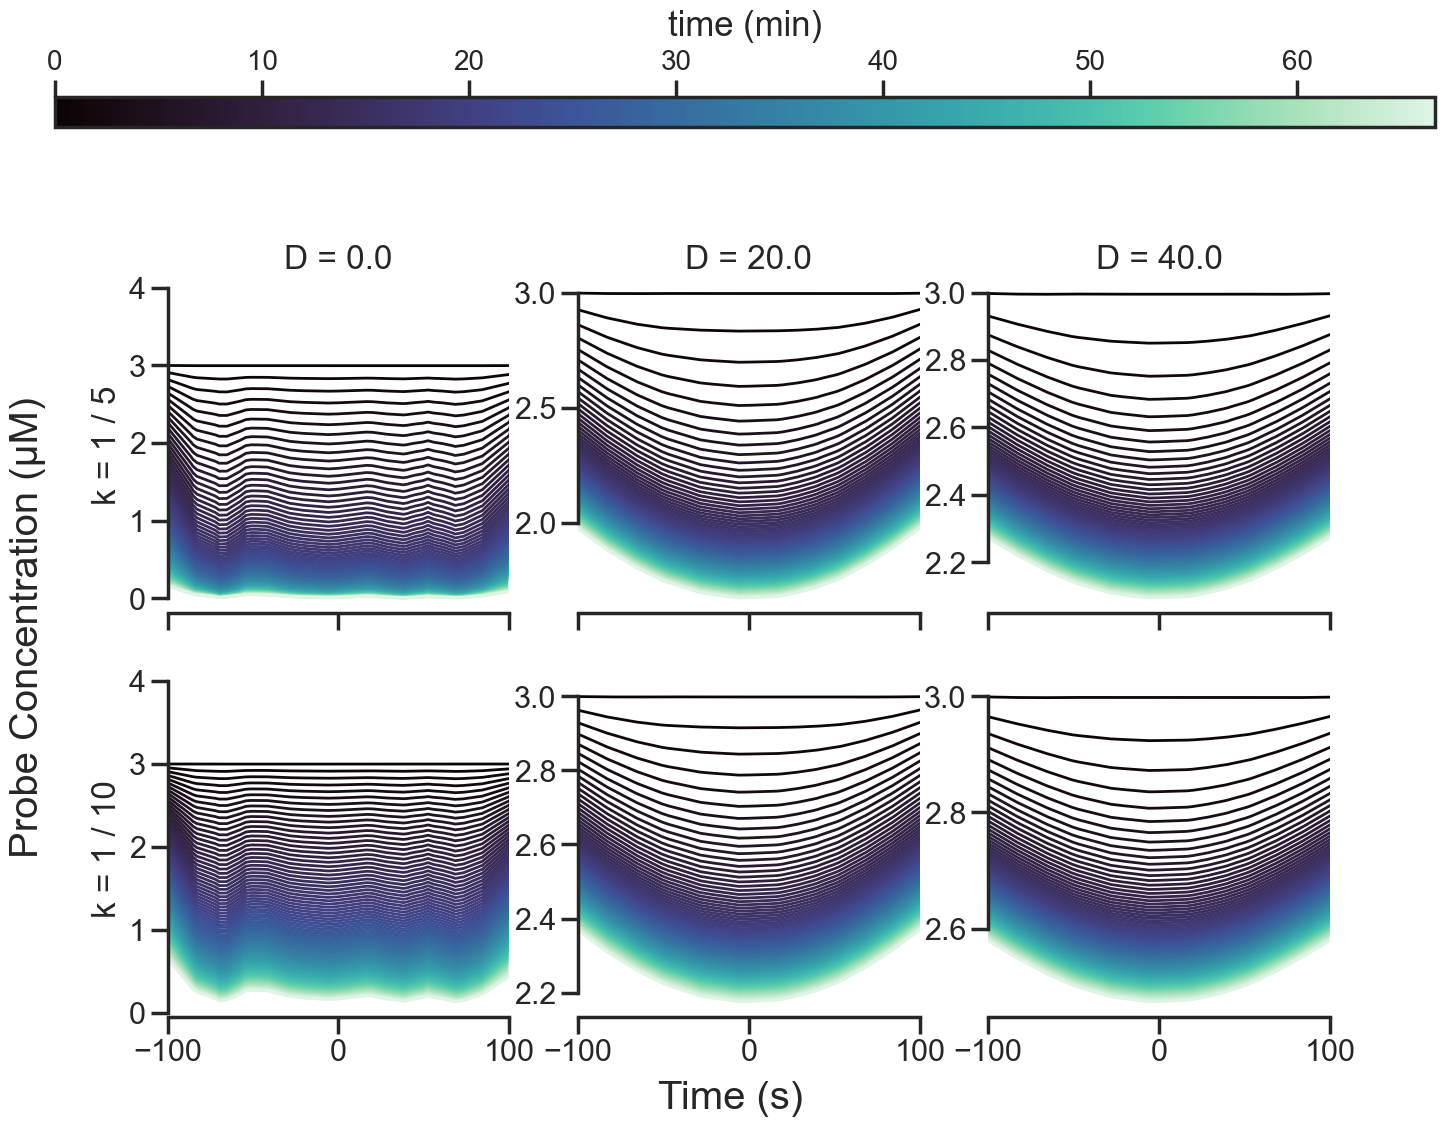

In [245]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(np.unique(cutLinedf['time'])))]

fig, ax = plt.subplots(len(np.unique(cutLinedf['kb'])), len(np.unique(cutLinedf['D'])), figsize = (15, 10), sharex=True)
for i, ki in enumerate(np.unique(cutLinedf['kb'])):
    ax[i][0].set_ylabel(f'k = 1 / {int(ki)}')
    for j, Dj in enumerate(np.unique(cutLinedf['D'])):
        ax[0][j].set_title(f'D = {Dj}')
        for t, time in enumerate(np.unique(cutLinedf['time'])):
            tempdf = cutLinedf[(cutLinedf['kb']==ki) & (cutLinedf['D']==Dj) & (cutLinedf['time']==time) & (cutLinedf['tint']==20)]
            ax[i][j].plot((tempdf['% Arc length (m)']-(np.max(tempdf['% Arc length (m)'])/2))*1e6, 
                          tempdf['Dependent variable u']*1000, lw=2, 
                          #label='D: '+str(tempdf['D'][0])+' um/s, k: '+str(tempdf['kb'][0])+' 1/s',
                          color=colorList[t], 
                          ls='-')
        # ax[i][j].fill_betweenx([tempdf['Dependent variable u'].min()*1000, tempdf['Dependent variable u'].max()*1000], -100, 100, color='gainsboro', zorder=0)
        # ax[i][j].fill_betweenx([tempdf['Dependent variable u'].min()*1000, tempdf['Dependent variable u'].max()*1000], -50, 50, color='ghostwhite', zorder=0)

#ax[0][0].set_ylim(0,3.1)
ax[0][0].set_xlim(-100,100)
fig.supylabel('Probe Concentration (µM)')
fig.supxlabel('Time (s)')
#stylish
sns.despine(trim=True)

######
# Adjust the top margin to make space for the colorbar
fig.subplots_adjust(top=0.85)

# Create an axis for the colorbar that spans all columns
cax = fig.add_axes([0.05, 1, 0.92, 0.03])  # [left, bottom, width, height]

# Create the colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=sns.color_palette("mako", as_cmap=True), norm=mcolors.Normalize(vmin=min(cutLinedf['time'])/60, 
                                                                 vmax=max(cutLinedf['time'])/60)),
                    cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=20)

# Move colorbar label and ticks to the top
cbar.ax.xaxis.set_ticks_position('top')   # Move ticks to top
cbar.ax.xaxis.set_label_position('top')   # Move label to top
cbar.set_label('time (min)', fontsize=25, labelpad=10)

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250516_cutLineTraceVarykandDCropped.pdf", bbox_inches='tight', transparent=True)

# modify  intervals

In [206]:
len(timeTraceNames)

6

0.054484133751613664
2.1852007693388003
2.9985800670253


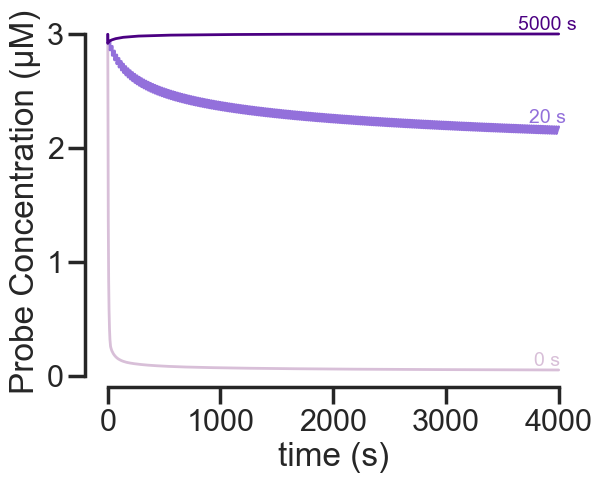

In [290]:
colorList = ['thistle', 'mediumpurple', 'indigo']
fig, ax = plt.subplots()
for i, timeint in enumerate(np.unique(timeTracedf['tint'])):
    tempdf = timeTracedf[(timeTracedf['kb']==5) & (timeTracedf['D']==40) & (timeTracedf['tint']==timeint)]
    ax.plot(tempdf['% Time (s)'], 
                      tempdf['Dependent variable u']*1000, lw=2, 
                      label='interval: '+str(timeint)+' s',
                      color=colorList[i],#color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3, 0.7), 
                      ls='-')
    ax.text(np.array(tempdf['% Time (s)'])[-1]-100, 
                      np.array(tempdf['Dependent variable u'])[-1]*10**3,
                      str(int(timeint))+' s',
                       ha='center',
                       va='bottom',
                       color=colorList[i],
                       fontsize=14,
           )#bbox=dict(facecolor='white', alpha=0.6))
    print(np.array(tempdf['Dependent variable u'])[-1]*1000)

ax.set_xlabel('time (s)')
ax.set_ylabel('Probe Concentration (µM)')
sns.despine(trim=True)


srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250519_varyIntervals.pdf", bbox_inches='tight', transparent=True)

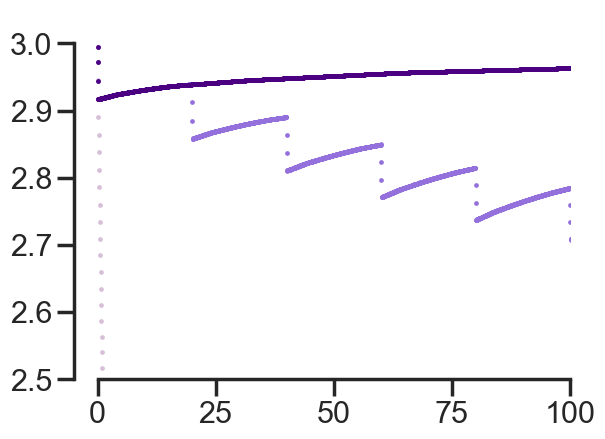

In [285]:
colorList = ['thistle', 'mediumpurple', 'indigo']
fig, ax = plt.subplots()
for i, timeint in enumerate(np.unique(timeTracedf['tint'])):
    tempdf = timeTracedf[(timeTracedf['kb']==5) & (timeTracedf['D']==40) & (timeTracedf['tint']==timeint)]
    ax.scatter(tempdf['% Time (s)'], 
                      tempdf['Dependent variable u']*1000, s=2, 
                      label='interval: '+str(timeint)+' s',
                      color=colorList[i],#color=(i/len(np.unique(timeTracedf['kb'])), j/len(np.unique(timeTracedf['D'])), 0.3, 0.7), 
                      ls='-')
ax.set_ylim(2.5, 3.05)
ax.set_xlim(-5, 100)
# ax.set_xlabel('time (s)')
# ax.set_ylabel('Probe Concentration (µM)')
sns.despine(trim=True)   

srcdir_anal = '../../analyzed_data/COMSOL/photobleaching/20250324_3D_nosurfbinding/'
#plt.savefig(srcdir_anal+"20250519_varyIntervalsZoom.pdf", bbox_inches='tight', transparent=True)